# Выделение сегментов с высоким уровнем оттока среди клиентов банка

**Описание проекта**

В региональном банке обнаружили высокий уровень оттока клиентов (физ. лиц). Привлечение новых клиентов обходится дорого, принято решение сфокусироваться на сохранении текущих. Нужно понять, какие клиенты наиболее склонны к уходу, чтобы маркетинговый отдел мог работать над их удержанием.

**Цель исследования** – выявить сегменты отточных пользователей. <br>
Результаты будут использоваться при проведении таргетированных маркетинговых кампаний по выделенным сегментам.

**План работы**

1. [Предобработка данных](#cleaning);
0. Исследовательский анализ данных:
    - [Отток в разрезе признаков](#attributes) – при каких значениях отток повышен;
    - [Портрет отточного и лояльного клиента](#profiles) – средние значения признаков;
    - [Корреляционный анализ](#corr);
0. [Проверка статистических гипотез](#stattest);
0. [Сегментация по стратегическим показателям](#segmentation);
0. [Общий вывод и рекомендации](#gen_concl);
0. [Презентация результатов анализа](#ppt).

**Данные**

Датасет `bank_scrooge.csv` – содержит перечень клиентов и их основные характеристики, а также признак отточности (клиент ушел или собирается уходить). Выгружен из внутренних систем банка.

## Подготовка данных

Импортируем нужные библиотеки и определим функции для предобработки.

In [2]:
# установка библиотеки phik
!pip install phik --quiet

In [3]:
# импорт библиотек

# панды
import pandas as pd
from pandas import option_context
from pandas.plotting import register_matplotlib_converters

# математика и прочее
import numpy as np
import scipy.stats as st
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OneHotEncoder

# визуализация
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from plotly import graph_objects as go

In [4]:
# определение функций для знакомства с данными

def preview(df):
    '''Выводит основную информацию о датафрейме, случайные 10 строк и количество полных дубликатов.'''
    print(df.info())
    display(df.sample(10, random_state=77))
    print(f'\nПолностью дублирующихся строк: {df.duplicated().sum()}')
    
def case_duplicates(df):
    '''Определяет, есть ли в текстовых столбцах датафрейма одинаковые значения, написанные в разном регистре.'''
    df = df.select_dtypes(include=['object'])
    duplicated_results = {}
    for col in df.columns:
        col_as_is = len(df[col].unique())
        col_lower = len(df[col].str.lower().unique())
        if col_lower < col_as_is:
            duplicated_results[col] = f'Одинаковых значений с разным регистром: {col_as_is - col_lower}'
        else:
            duplicated_results[col] = 'Дубликатов по регистру нет.'
    (
        display(pd.DataFrame.from_dict(duplicated_results, orient='index')
                .reset_index().set_axis(labels=['Столбец', 'Результат'], axis=1))
    )
    
def na_detector(df):
    '''Возвращает число и процент пропусков по столбцам (только те столбцы, в которых есть пропуски).'''
    na_cols = pd.DataFrame(
            {'Число_пропусков' : df.isna().sum(), 
             'Процент' : round(df.isna().mean()*100, 1)}
                            ).query('Число_пропусков > 0')
    return na_cols

def na_pct_by_col(df, grouping_col='col'):
    '''Группирует данные по указанному столбцу и рассчитывает процент пропусков для каждой группы 
    для всех признаков, где есть пропущенные значения. 
    
    Использует функцию na_detector.
    Для группировки лучше использовать признак без пропусков.'''
    na_cols = na_detector(df)
    na_grouped_dict = {}
    if grouping_col == 'col':
        print('Не указан столбец для группировки.')
    else:
        for col in na_cols.index:
            na_grouped_dict[col] = (
                df.groupby(grouping_col).apply(lambda x: round(x[col].isna().mean()*100, 1))
            )
        na_grouped = pd.DataFrame(na_grouped_dict).T
        return na_grouped

### Загрузка и просмотр исходных данных

Загрузим и сохраним датасет.

In [5]:
# путь расположения файла
path = 'https://code.s3.yandex.net/datasets/'
# имя файла
data = 'bank_scrooge.csv'

df_raw = pd.read_csv(path + data)

Просмотрим основную информацию об исходных данных.

In [6]:
preview(df_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
7410,228447,697.0,Ярославль,М,34.0,0,NaN,1,1,1,98405.58,0
261,166341,920.0,Ярославль,М,39.0,0,NaN,1,1,0,146488.41,0
8425,193421,850.0,Ярославль,Ж,33.0,2,281967.38,1,1,0,43270.84,0
722,141712,824.0,Ростов,М,31.0,3,657708.00,2,1,1,110337.25,1
3106,185748,912.0,Ярославль,Ж,47.0,5,1598218.98,2,0,0,180256.98,0
425,198197,826.0,Рыбинск,Ж,30.0,7,353971.23,1,1,1,56220.84,0
2137,118280,905.0,Ростов,Ж,51.0,0,NaN,1,0,1,71480.01,0
6479,200342,857.0,Рыбинск,М,50.0,6,542413.88,2,0,1,93046.86,1
5034,214203,887.0,Ростов,М,58.0,5,884880.40,2,0,1,54109.81,1
3433,180326,985.0,Ярославль,Ж,35.0,4,345673.48,3,0,1,29534.20,0



Полностью дублирующихся строк: 0


Имеем данные о 10 тысячах клиентов.

Что о них известно:
- Уникальный идентификатор;
- Балл кредитного скоринга (чем он выше, тем более надежен клиент);
- Город;
- Пол;
- Возраст;
- Количество баллов собственности (оценка суммарной стоимости высоколиквидного имущества, о наличии которого клиент сообщил банку);
- Баланс на счете;
- Количество продуктов, которыми пользуется клиент;
- Наличие кредитной карты;
- Проявлял ли клиент активность в течение последнего месяца (клиент совершил операцию или обратился в банк);
- Размер заработной платы (рассчитывается на основании движения и объема денежных средств клиента);
- Признак отточности (клиенты, которые неоднократно выражали намерение уйти, тоже считаются отточными).

**Выводы по исходным данным**

Размер датасета – 10000 наблюдений. Качество данных в целом хорошее.

Обнаруженные проблемы для этапа предобработки:
- Пропущенные значения в столбцах возраста и баланса на счете – исследуем природу;
- Стилистика названий столбцов – переименуем.

<a id='cleaning'></a>
### Предобработка данных

Подготовим данные для анализа. Найдем и обработаем:
1. Пропуски;
0. Выбросы;
0. Неявные дубликаты;
0. Некорректные значения.

#### Пропущенные значения
<a id='nans'></a>

В столбцах `age` и `balance` некоторые значения отсутствуют. 

Возраст клиента банку обязательно известен. Пропуски в этом признаке имеют техническую природу – вероятно, часть данных о возрасте по какой-то причине не выгрузилась, либо потерялась еще до момента выгрузки.

Баланс на счете рассчитывается автоматически. Возможны варианты:
- Значения не выгрузились;
- Значения не рассчитались до выгрузки данных по технической ошибке;
- Значения отсутствуют и это нормально (такое может быть возможно, например, для клиентов, которые ушли из банка и закрыли все продукты; нет счета – нет баланса). 

Попробуем лучше понять природу и распределение пропусков, посмотрев на их процент в разбивке по разным группам клиентов.

Сначала рассчитаем процент пропусков для обоих столбцов.

In [7]:
na_detector(df_raw)

,Число_пропусков,Процент
age,26,0.3
balance,2295,23.0


Доля пропусков в столбце `age` не критична, однако признак `balance` отсутствует почти у четверти наблюдений. Это значительное количество.

Сгруппируем данные по всем категориальным признакам и рассчитаем процент пропусков в разбивке по каждому из них.

In [8]:
for i in ['city', 'gender', 'credit_card', 'last_activity', 'churn']:
    display(na_pct_by_col(df_raw, i))

city,Ростов,Рыбинск,Ярославль
age,0.1,0.4,0.2
balance,16.6,22.0,24.9


gender,Ж,М
age,0.2,0.3
balance,20.3,25.6


credit_card,0,1
age,0.2,0.3
balance,13.2,27.5


last_activity,0,1
age,0.1,0.4
balance,21.7,24.1


churn,0,1
age,0.3,0.1
balance,27.9,0.7


О столбце `age` сложно что-то сказать – пропусков всего 26 штук, и сравнивать их доли по категориям нецелесообразно при объеме датасета в 10 тысяч наблюдений. 

По доле пропусков в `balance` есть значительная разница:
- Между отточными и лояльными клиентами – почти все пропуски у лояльных;
- У имеющих кредитную карту клиентов процент пропусков вдвое больше, чем у неимеющих;
- Меньше пропусков в Ростове.

Посмотрим на то, зависят ли пропуски в `balance` от числовых признаков – посмотрим, отличаются ли средние и медианные значения числовых столбцов тех клиентов, у которых баланс не указан.

In [9]:
print(f'С пропусками в balance (23% данных, {len(df_raw.query("balance.isna()"))} наблюдений):')
display(df_raw.query('balance.isna()').describe().loc[['mean', '50%']].drop(['USERID', 'balance'], axis=1))

print(f'Где balance заполнен (77% данных, {len(df_raw.query("~balance.isna()"))} наблюдений):')
display(df_raw.query('~balance.isna()').describe().loc[['mean', '50%']].drop(['USERID', 'balance'], axis=1))

С пропусками в balance (23% данных, 2295 наблюдений):


,score,age,equity,products,credit_card,last_activity,EST_SALARY,churn
mean,865.35207,42.093023,0.05098,1.162092,0.815686,0.549455,226310.208654,0.005664
50%,903.00000,40.000000,0.00000,1.000000,1.000000,1.000000,174160.680000,0.000000


Где balance заполнен (77% данных, 7705 наблюдений):


,score,age,equity,products,credit_card,last_activity,EST_SALARY,churn
mean,843.73926,42.924366,3.395068,2.080986,0.640104,0.515769,124501.872366,0.234523
50%,840.00000,40.000000,4.000000,2.000000,1.000000,1.000000,106222.200000,0.000000


Видна разница средних в `churn` – баланс не заполнен почти исключительно у лояльных клиентов.

Также заметно расхождение средних значений по `equity`, числу баллов собственности. Практически все клиенты с пропусками в балансе имеют ноль баллов, тогда как у остальных в среднем 4 балла.

По заработной плате `EST_SALARY` тоже есть различие – пропуски в балансе соотносятся с более высокими суммами зарплат.

Итого, наличие пропусков в `balance` может быть связано со значениями других признаков:
- Лояльность;
- Отсутствие собственности;
- Более высокая зарплата.

Можно отметить, что медиана по баллам кредитного скоринга у пропусков превышает среднее – значит, распределение скошено влево. 

Построим гистограммы распределения по некоторым числовым признакам для клиентов с указанным и отсутствующим балансом.

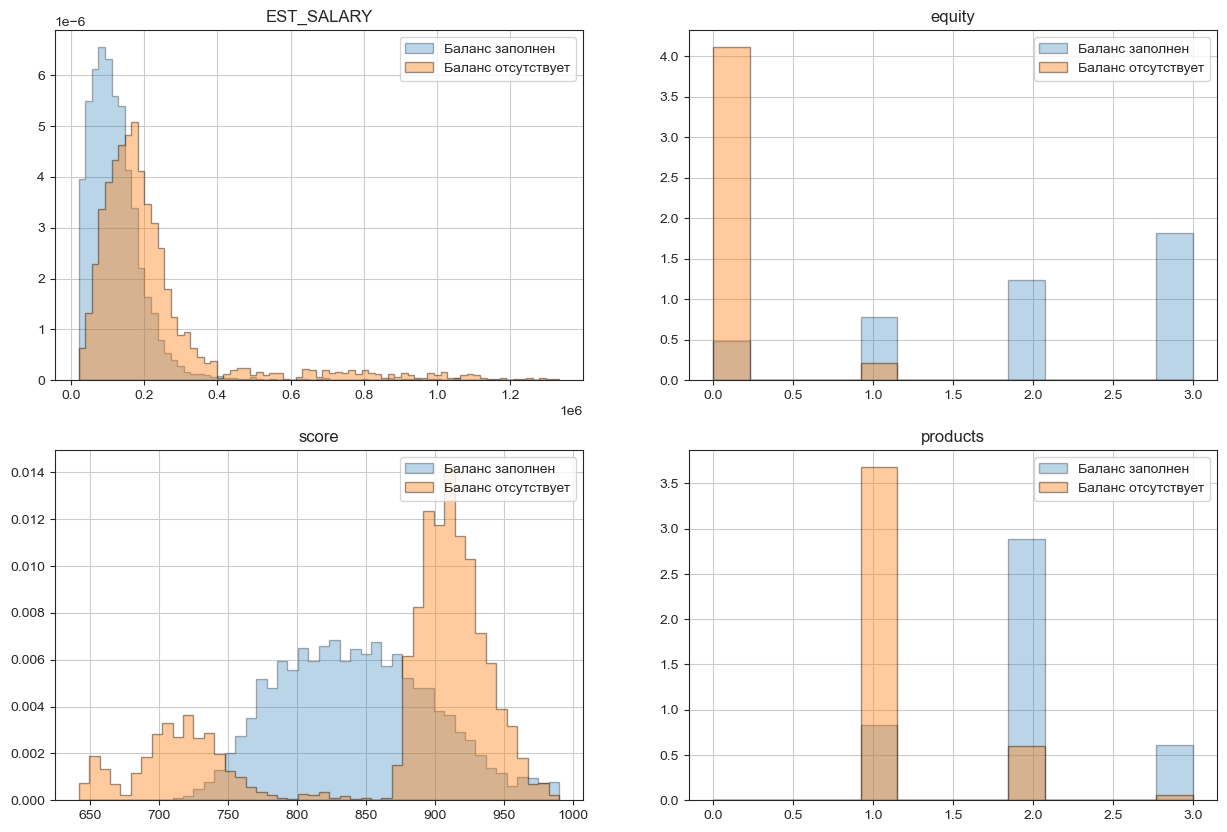

In [10]:
sns.set_style('ticks')

hist_cols = ['EST_SALARY', 'equity', 'score', 'products']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    no_balance = df_raw.query('balance.isna()')[hist_cols[i]]
    yes_balance = df_raw.query('~balance.isna()')[hist_cols[i]]
    
    counts, bins = np.histogram(no_balance, bins='auto')

    yes_balance.hist(bins=bins, density=True, alpha=0.3, histtype='stepfilled', 
                     edgecolor='k', label='Баланс заполнен', ax=ax);
    no_balance.hist(bins=bins, density=True, alpha=0.4, histtype='stepfilled', 
                    edgecolor='k', label='Баланс отсутствует', ax=ax);
    
    ax.set_title(hist_cols[i])
    ax.legend(loc=1);

Видно, что пропуски распределены не случайно. Признаки и значения, связанные с высокой долей пропусков в `balance`:
- `score` – высокий (от 875) или низкий (до 775);
- `equity` – 0 баллов;
- `products` – 1 продукт;
- `EST_SALARY` – чем выше, тем больше пропусков.

Таким же образом рассмотрим пропуске в столбце `age`. Сравним средние и медианы числовых столбцов между строками с заполненными и отсутствующими значениями.

In [11]:
print(f'С пропусками в age (0.3% данных, {len(df_raw.query("age.isna()"))} наблюдений):')
display(df_raw.query('age.isna()').describe().loc[['mean', '50%']].drop(['USERID', 'age'], axis=1))

print(f'Где age заполнен (99.7% данных, {len(df_raw.query("~age.isna()"))} наблюдений):')
display(df_raw.query('~age.isna()').describe().loc[['mean', '50%']].drop(['USERID', 'age'], axis=1))

С пропусками в age (0.3% данных, 26 наблюдений):


,score,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
mean,855.153846,1.384615,1250033.573,1.346154,0.769231,0.769231,178585.199231,0.038462
50%,888.500000,0.000000,417361.115,1.000000,1.000000,1.000000,142598.860000,0.000000


Где age заполнен (99.7% данных, 9974 наблюдений):


,score,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
mean,848.682575,2.63084,827245.587515,1.871466,0.680168,0.522859,147786.809731,0.182374
50%,853.000000,3.00000,524295.330000,2.000000,1.000000,1.000000,119626.795000,0.000000


Здесь снова видим, что почти все клиенты с пропусками лояльные. Среди них также выше процент активных и с кредитными картами.

Аналогичная ситуация с признаками `equity`, `products`, `EST_SALARY` – собственности и продуктов у клиентов без возраста меньше, а зарплата чуть выше. Распределение `score` тоже смещено влево.

Построим гистограммы этих признаков с делением по наличию/отсутствию значения `age`.

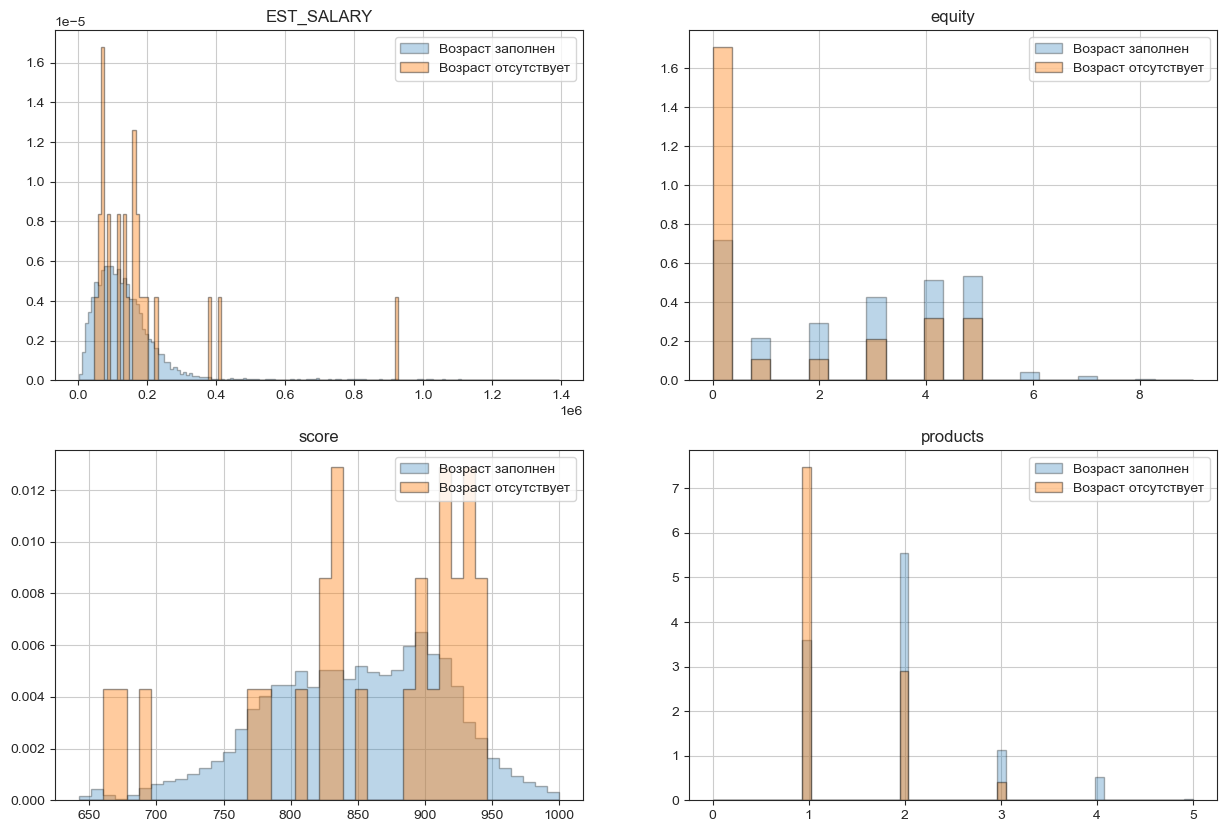

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    no_age = df_raw.query('age.isna()')[hist_cols[i]]
    yes_age = df_raw.query('~age.isna()')[hist_cols[i]]
    
    counts, bins = np.histogram(yes_age, bins='auto')
    
    yes_age.hist(bins=bins, density=True, alpha=0.3, histtype='stepfilled', 
                 edgecolor='k', label='Возраст заполнен', ax=ax);
    no_age.hist(bins=bins, density=True, alpha=0.4, histtype='stepfilled', 
                edgecolor='k', label='Возраст отсутствует', ax=ax);

        
    ax.set_title(hist_cols[i])
    ax.legend(loc=1);

Читать графики сложнее, так как размер группы с пропусками крайне мал. Тем не менее, можно выделить те же тенденции, что по признаку `balance`. Оба признака с пропусками не заполнены примерно у одних и тех же групп.

Посмотрим, насколько группы с пропусками пересекаются.

In [13]:
len(df_raw.query('balance.isna() & age.isna()'))

16

Из 26 строк с пропусками в `age` 16 также не имеют значений в `balance`. Посмотрим на все строки о клиентах без возраста, отсортировав по убыванию баланса.

In [14]:
df_raw.query('age.isna()').sort_values(by='balance', ascending=False)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
9667,163657,849.0,Ярославль,М,NaN,4,1254013.85,2,1,1,119106.67,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
9104,222480,776.0,Рыбинск,Ж,NaN,5,796735.09,1,1,1,55073.63,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0
7409,214031,777.0,Ярославль,М,NaN,2,171510.23,1,1,1,75409.63,0


Строки, где пропущены оба значения, имеют много общего:
- У всех ноль баллов собственности и ровно один продукт;
- Все отмечены как лояльные;
- 14 из 16 имеют кредитку.

По всем строкам с пропущенным возрастом:
- Все, кроме одного, лояльные;
- Только один клиент из Ростова, остальные – Ярославль или Рыбинск.

Точную природу происхождения невозможно установить по имеющимся данным. Возможно, эти клиенты пользуются определенным видом продукта, либо ушли из банка, но имеют неисполненные обязательства и поэтому все еще числятся как клиенты. Для выявления таких зависимостей нужна дополнительная информация.

Заполнять неслучайные пропуски без уверенности в причине их появления некорректно.

Доля отсутствующих значений в `age` незначительна (менее 1% в любой группе), она не должна повлиять на результаты анализа. При последующем изучении средних значений по `balance` нужно учесть, что из расчетов выпадает определенная доля лояльных клиентов – около 1/4.

#### Аномальные значения

Проверим количественные признаки на наличие выбросов:
- Для непрерывных признаков и дискретных с большим числом уникальных значений построим гистограммы распределения;
- Для числовых столбцов с баллами собственности и числа продуктов выведем уникальные значения.

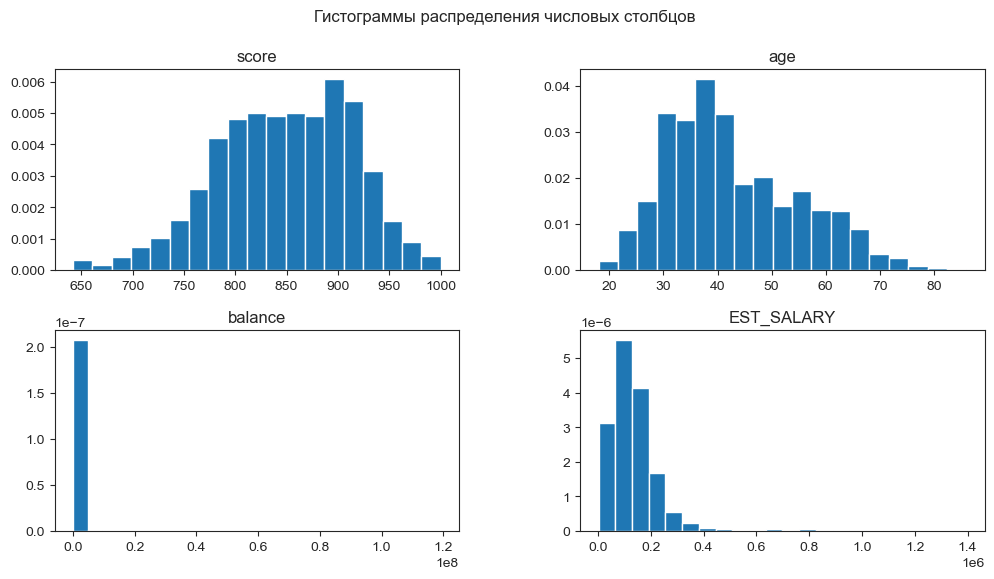

In [15]:
df_raw[['score', 'age', 'balance', 'EST_SALARY']].hist(figsize=(12,6), grid=False,
                                                       bins='doane', density=True)
plt.suptitle('Гистограммы распределения числовых столбцов');

Видно наличие выбросов в столбцах `balance` и `EST_SALARY` – баланс и зарплата.

Рассмотрим средние значения по столбцу баланса на счете.

In [16]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_raw['balance'].describe()

count        7705.00
mean       827794.31
std       1980614.15
min             0.00
25%        295554.16
50%        524272.20
75%        980705.85
max     119113552.01
Name: balance, dtype: float64

Похоже, кто-то хранит на счете 112 миллионов. Медиана составляет около 524 тыс. рублей.

Рассчитаем 90-й, 95-й и 99-й перцентили по столбцу – суммы баланса, ниже которых 90, 95 и 99 процентов значений соответственно.

In [17]:
list(np.percentile(df_raw['balance'].dropna(), [90,95,99]))

[1460133.708, 2116704.7839999963, 4827443.494]

Менее 1% клиентов хранят на счету более 5 млн рублей.

Посмотрим на средние и крайние значения по столбцу зарплаты.

In [18]:
df_raw['EST_SALARY'].describe()

count     10000.00
mean     147866.89
std      139388.51
min        2546.30
25%       75251.90
50%      119658.10
75%      174500.54
max     1395064.45
Name: EST_SALARY, dtype: float64

Медианная зарплата – 120 тысяч, но есть клиент с заработком в 1.4 млн. Рассчитаем 90-й, 95-й и 99-й перцентили столбца.

In [19]:
list(np.percentile(df_raw['EST_SALARY'].dropna(), [90,95,99]))

[242395.782, 316885.3445, 887903.8546000007]

99% клиентов получают менее 888 тысяч.

Построим совмещенную диаграмму рассеяния по балансу на счете и зарплате. На графике также отметим уровни, соответствующие рассчитанным перцентилям.

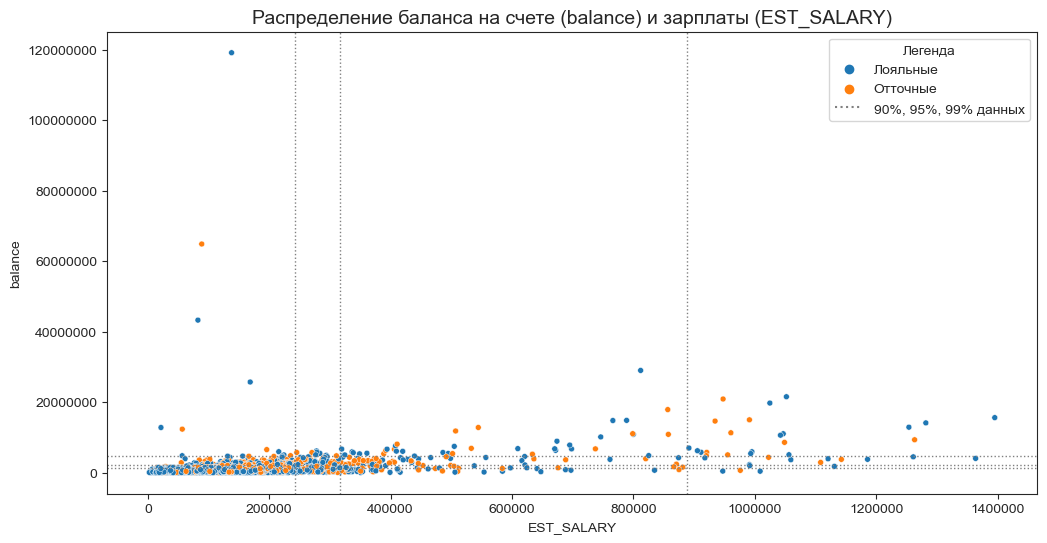

In [20]:
plt.figure(figsize=(12,6))
plt.title('Распределение баланса на счете (balance) и зарплаты (EST_SALARY)', fontsize=14)

scatter_ax = sns.scatterplot(data=df_raw, x='EST_SALARY', y='balance', hue='churn', s=18)

for i in [90,95,99]:
    plt.axhline(y=np.percentile(df_raw['balance'].dropna(), i), lw=1, ls=':', c='grey')
    plt.axvline(x=np.percentile(df_raw['EST_SALARY'], i), lw=1, ls=':', c='grey')

plt.ticklabel_format(style='plain')

handles, labels = scatter_ax.get_legend_handles_labels()
percentile_line = mlines.Line2D([], [], c='grey', ls=':', ms=15)
handles.append(percentile_line)
plt.legend(handles=handles, labels=['Лояльные', 'Отточные', '90%, 95%, 99% данных'], title='Легенда')

plt.grid(False);

Видно, что в целом экстремальные значения соотносятся – аномально высокий остаток на счете в основном встречается у клиентов с аномально высокой зарплатой. Однако по балансу есть выбросы в левой части графика, где зарплаты низкие. Наличие таких значений сильно сместит средние для группы клиентов с обычным или низким заработком. Ограничим диапазон нормальных значений баланса на уровне 10 млн: это позволит исключить такие выбросы.

Экстремальные значения зарплат распределены более равномерно, самые крайние суммы не так далеко отстоят от основной массы значений. Клиенты с высоким заработком в целом выгодны для банка, поэтому их важно учесть при анализе отточности. С другой стороны, цель исследования – выявление крупных сегментов, которые можно таргетировать маркетингом. Клиенты с аномально высокой зарплатой при этом войдут в группу просто много зарабатывающих (для отдельной категории их слишком мало), а те будут представлены в датасете и после исключения выбросов.

Построим диаграмму размаха для столбца `EST_SALARY`, чтобы посмотреть на распределение выбросов, и добавим разбивку по отточности. Из диаграммы исключим клиентов, которые отпадут сами после ограничения данных по `balance`.

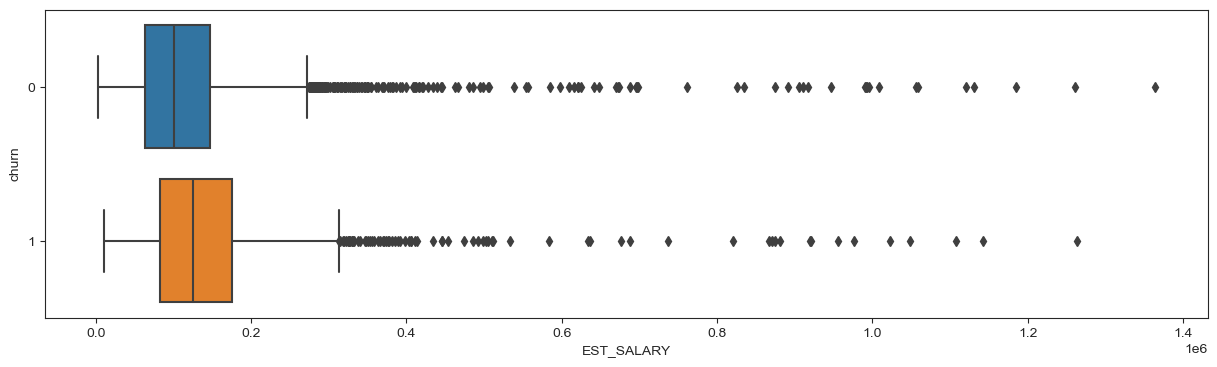

In [21]:
plt.figure(figsize=(15,4))
sns.boxplot(data=df_raw.query('balance <= 10000000'), x='EST_SALARY', y='churn', orient='h');

Число аномальных клиентов с увеличением зарплаты уменьшается постепенно, но есть удобный промежуток на уровне 800 тысяч. Все эти значения являются выбросами, чем их больше, тем больше сместятся средние при последующих расчетах. Ограничим диапазон нормальных зарплат на уровне 800 тыс. (менее 5% клиентов) и найдем число исключенных записей по обоим признакам – `balance` и `EST_SALARY`.

In [22]:
outliers = df_raw.query('balance > 10000000 | EST_SALARY > 800000')
print(
f'Число выбросов: {len(outliers)}\n\
Процент: {len(outliers)/len(df_raw)*100}%\n\
Уровень оттока в выбросах: {outliers["churn"].mean()*100:.2f}%\n\
Средний уровень оттока по всем данным: {df_raw["churn"].mean()*100:.2f}%'
)

Число выбросов: 151
Процент: 1.51%
Уровень оттока в выбросах: 17.22%
Средний уровень оттока по всем данным: 18.20%


#### Неявные дубликаты

Полных дубликатов в данных нет. Попробуем обнаружить идентичных клиентов, данные о которых дублируются не полностью.

Сначала проверим, нет ли в тестовых столбцах одинаковых значений, записанных в разном регистре.

In [23]:
case_duplicates(df_raw)

,Столбец,Результат
0,city,Дубликатов по регистру нет.
1,gender,Дубликатов по регистру нет.


Таких значений нет, отлично. 

Поищем также строки, где совпадает ключевая для идентификации пользователя информация, но некоторые второстепенные признаки различаются. Здесь достаточно одного столбца `USERID` – известно, что уникальные идентификаторы не повторяются, даже если клиент ушел из банка и снова вернулся. Проверим, есть ли в данных дублирующиеся идентификаторы.

In [24]:
df_raw.duplicated(subset='USERID').sum()

73

Такие дубли есть. Посмотрим информацию об этих клиентах (первые 8 парных идентификаторов).

In [25]:
uid_doubles = df_raw[df_raw.duplicated(subset='USERID', keep=False)].sort_values(by=['USERID', 'churn'])
uid_doubles.head(16)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
7694,116540,887.00,Ярославль,Ж,38.00,0,NaN,1,0,1,119247.61,0
1893,116540,883.00,Рыбинск,Ж,55.00,1,362756.49,3,0,1,175920.48,1
7542,117943,880.00,Ярославль,Ж,40.00,0,NaN,1,1,0,137718.93,0
4866,117943,855.00,Рыбинск,Ж,32.00,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.00,Ярославль,М,30.00,0,NaN,1,1,1,146427.96,0
5863,120258,908.00,Рыбинск,Ж,38.00,4,2213581.63,2,0,1,160327.77,1
8638,123461,934.00,Рыбинск,М,34.00,0,NaN,2,1,0,291619.27,0
1411,123461,829.00,Ярославль,Ж,59.00,0,96222.44,2,0,1,102771.55,1
9775,124450,758.00,Рыбинск,Ж,36.00,0,73574.07,2,0,1,79963.59,0
8164,124450,859.00,Ярославль,Ж,38.00,6,516811.20,1,1,1,95144.63,1


По 8 клиентам из 73 можно заметить некоторые особенности:
- У клиентов-дубликатов разный город, пока только Ярославль или Рыбинск;
- Некоторые при переезде меняют пол;
- У одной из дублирующихся записей может отсутствовать баланс и/или возраст, но не обязательно;
- Некоторые в одном городе отмечены как лояльные, а в другом как отточные (причем клиенты с пропусками лояльные).

Проверим предположение о том, что записи дублируются между двумя городами: посчитаем число дублей в каждом.

In [26]:
uid_doubles.groupby('city').size()

city
Рыбинск      73
Ярославль    73
dtype: int64

Также проверим, нет ли дубликатов внутри одного города. Сопоставим число уникальных `USERID` в каждом.

In [27]:
uid_doubles.groupby('city')['USERID'].nunique()

city
Рыбинск      73
Ярославль    73
Name: USERID, dtype: int64

Записи дублируются именно между данными о Рыбинске и Ярославле.

Так как пол и возраст у клиентов-двойников разный, можно заключить, что это не одни и те же люди, просто сменившие место жительства. Вероятнее всего, в системе банка могут происходить технические ошибки при первичной регистрации клиентов в этих двух городах. С этим также может быть связано наличие пропущенных значений в `balance` и `age`.

Проверим число пропусков среди дубликатов в каждом городе.

In [28]:
for i in ['Ярославль', 'Рыбинск']:
    print(i)
    display(na_detector(uid_doubles.query("city == @i")))

Ярославль


,Число_пропусков,Процент
age,12,16.40
balance,24,32.90


Рыбинск


,Число_пропусков,Процент
age,11,15.10
balance,25,34.20


В Ярославле и Рыбинске пропущено почти одинаковое число значений.

Таким же образом сгруппируем дубликаты по отточности и снова рассчитаем процент пропусков.

In [29]:
_ = {0 : 'Лояльные', 1 : 'Отточные'}
for i in _:
    print(_[i])
    display(na_detector(uid_doubles.query("churn == @i")))

Лояльные


,Число_пропусков,Процент
age,23,24.00
balance,49,51.00


Отточные


,Число_пропусков,Процент


Пропуски есть только у лояльных клиентов-дубликатов.

Рассчитаем процент отточных среди дубликатов в каждом городе.

In [30]:
uid_doubles.groupby('city')['churn'].mean()

city
Рыбинск     0.29
Ярославль   0.40
Name: churn, dtype: float64

В Ярославле больше клиентов, отмеченых как отточные.

Наконец, рассчитаем среднее и медиану по всем столбцам дублирующихся строк.

In [31]:
uid_doubles.drop('USERID', axis=1).describe().loc[['mean', '50%']]

,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
mean,861.99,41.08,2.45,1136248.44,2.01,0.68,0.65,167776.81,0.34
50%,881.00,38.00,3.00,648594.03,2.00,1.00,1.00,132973.84,0.00


Уровень оттока выше, чем средний по датасету, но другие значения в норме.

Между дубликатами в двух городах есть некоторые закономерности в части того, как признак отточности соотносится с отсутствующими значениями. Эти записи могут сместить средние значения оттока по всему городу. Мы также не можем быть уверены в корректности остальных данных таких строк. По этим причинам исключим из данных всех клиентов с дублирующимися индектификаторами.

In [32]:
print(
f'Число неявных дубликатов по USERID (считаются обе строки): {len(uid_doubles)}\n\
Процент: {len(uid_doubles)/len(df_raw)*100}%\n\
Уровень оттока в выбросах: {uid_doubles["churn"].mean()*100:.2f}%\n\
Средний уровень оттока по всем данным: {df_raw["churn"].mean()*100:.2f}%'
)

Число неявных дубликатов по USERID (считаются обе строки): 146
Процент: 1.46%
Уровень оттока в выбросах: 34.25%
Средний уровень оттока по всем данным: 18.20%


#### Корректность заполнения данных

Проверим данные на наличие некорректных значений:
- Возраст клиента менее 18, а также максимальное значение;
- Число продуктов, которыми пользуется клиент, равное нулю (особенно при наличии кредитной карты);
- Уникальные значения города и пола.

In [33]:
print(f'Клиентов моложе 18 лет: {df_raw.query("age < 18").shape[0]}')
print(f'Самый старший клиент: {int(df_raw["age"].max())} лет')

Клиентов моложе 18 лет: 0
Самый старший клиент: 86 лет


С возрастом клиентов все в порядке. 

Так как столбец с возрастом не целочисленный (из-за наличия пропусков), проверим, есть ли записи, где значение имеет десятичные знаки (например, возраст 40.3).

In [34]:
_ = []
for i in df_raw['age'].dropna().values:
    _.append(not i.is_integer())
sum(_)

0

Тоже все хорошо. Перейдем к проверке на клиентов с нулем продуктов.

In [35]:
df_raw.query('products < 1')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,25063.96,1


Только один клиент без продуктов банка. Проверим, есть ли он среди дубликатов по идентификатору.

In [36]:
np.isin(df_raw.query('products < 1').index, uid_doubles.index)[0]

False

Клиент из Рыбинска не входит в число дубликатов, хотя у него тоже отсутствует баланс. При этом он отмечен как отточный – возможно, баланса и продуктов нет, потому что клиент ушел и все продукты закрыты. В таком случае отток клиента случился более месяца назад.

Исключим его из данных.

Выведем уникальные значения городов и пола.

In [37]:
list(df_raw['city'].unique())

['Рыбинск', 'Ярославль', 'Ростов']

In [38]:
list(df_raw['gender'].unique())

['Ж', 'М']

С этими столбцами порядок.

#### Выводы по предобработке и внесение изменений

Исходный размер датасета – 10 тысяч наблюдений, 12 признаков.

В ходе предобработки обнаружены **проблемы**:
1. Пропущенные значения в столбцах `balance` (23%) и `age` (0.3%):
- Могут быть корректными (основаны на признаке, которого нет в данных) – основная масса этих данных имеет общие характеристики:
    - Балл кредитного скоринга низкий или высокий;
    - Ноль баллов собственности;
    - Один продукт в банке;
    - Зарплата выше, чем у строк без пропусков.
2. Аномально высокие значения в столбцах `balance` и `EST_SALARY`;
<br><br>
3. Дублирующиеся уникальные идентификаторы в столбце `USERID`:
- Дублирование произошло между двумя городами – Ярославлем и Рыбинском;
- Это разные клиенты;
- Есть закономерности по признаку отточности и связь с наличием пропусков.
4. Клиент с 0 продуктов.

По итогам предобработки в датасет внесены **изменения**:
- Для большей точности последующих расчетов ограничен дапазон нормальных значений:
    - `balance` – до 10 млн рублей на счете;
    - `EST_SALARY` – до 800 тыс. рублей.
- Исключены строки с дублирующимися уникальными идентификаторами;
- Исключен клиент с 0 продуктов;
- Названия столбцов изменены на стилистически корректные;
- Для удобства отображения на графиках столбцы с балансом и зарплатой переведены из рублей в тысячи;
- Столбец кредитного скоринга переведен в целочисленный.

Для рассчета корреляции методом Спирмена по текстовым признакам (`city` и `gender`) добавлены столбцы с числовой кодировкой:
- Для признака `gender`: бинарный столбец `is_female`, где женщины имеют значение 1, мужчины – 0;
- Для признака `city`: бинарные столбцы для каждого города – локация клиента отмечается значением 1 в соответствующем столбце, в остальных столбцах – 0.

In [39]:
# сохраним измененный датасет в новой переменной и переименуем столбцы
df = df_raw.copy()
df.rename(columns={'USERID' : 'user_id',
                  'EST_SALARY' : 'salary'}, inplace=True)
# переводим рубли в тысячи рублей
df['balance'] = df['balance']/1000
df['salary'] = df['salary']/1000
# исключаем аномалии
df.drop(df.query('balance > 10000 | salary > 800').index, inplace=True)
# исключаем дублирующиеся идентификаторы
df.drop(uid_doubles.index, inplace=True, errors='ignore')
# исключаем клиента с 0 продуктов
df.drop(df_raw.query('products == 0').index, inplace=True, errors='ignore')
# переводим балл кредитного скоринга в целочисленный тип данных
df['score'] = df['score'].astype('int')

# создаем бинарные столбцы для городов
encoder = OneHotEncoder(sparse=False)
city_cols = encoder.fit_transform(df['city'].values.reshape(-1, 1))
city_cols = pd.DataFrame(city_cols, columns=encoder.categories_[0]).astype('int')
df = df.join(city_cols.set_index(df.index))
# добавляем бинарный столбец по полу
df['is_female'] = (df['gender'] == 'Ж').astype('int')

In [40]:
# проверим заполнение бинарных столбцов по городам через расчет среднего
df.groupby('city')[['Ростов', 'Рыбинск', 'Ярославль']].mean()

,Ростов,Рыбинск,Ярославль
city,,,
Ростов,1.00,0.00,0.00
Рыбинск,0.00,1.00,0.00
Ярославль,0.00,0.00,1.00


In [41]:
# таким же образом проверим бинарный столбец по полу
df.groupby('gender')['is_female'].mean()

gender
Ж   1.00
М   0.00
Name: is_female, dtype: float64

Просмотрим основную информацию об измененном датасете.

In [42]:
preview(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9707 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9707 non-null   int64  
 1   score          9707 non-null   int64  
 2   city           9707 non-null   object 
 3   gender         9707 non-null   object 
 4   age            9704 non-null   float64
 5   equity         9707 non-null   int64  
 6   balance        7549 non-null   float64
 7   products       9707 non-null   int64  
 8   credit_card    9707 non-null   int64  
 9   last_activity  9707 non-null   int64  
 10  salary         9707 non-null   float64
 11  churn          9707 non-null   int64  
 12  Ростов         9707 non-null   int64  
 13  Рыбинск        9707 non-null   int64  
 14  Ярославль      9707 non-null   int64  
 15  is_female      9707 non-null   int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 1.5+ MB
None


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,Ростов,Рыбинск,Ярославль,is_female
4313,228608,954,Ярославль,М,54.00,8,6716.01,2,0,1,319.40,0,0,0,1,0
3295,145142,915,Рыбинск,Ж,58.00,5,1432.80,1,1,1,64.99,0,0,1,0,1
8995,139822,896,Ярославль,Ж,18.00,0,NaN,1,1,1,51.69,0,0,0,1,1
4549,142475,994,Ярославль,Ж,31.00,2,228.45,2,1,0,44.43,0,0,0,1,1
7592,137993,841,Ярославль,М,33.00,5,840.14,2,1,0,105.93,0,0,0,1,0
5378,140493,867,Рыбинск,Ж,27.00,5,735.81,2,1,1,39.69,0,0,1,0,1
3805,121649,744,Ярославль,М,58.00,1,140.40,2,1,1,155.36,0,0,0,1,0
7265,135237,919,Ярославль,М,44.00,0,NaN,2,1,1,238.33,0,0,0,1,0
5764,229058,875,Ярославль,М,54.00,4,3680.35,3,0,1,173.79,1,0,0,1,0
8823,187537,839,Ярославль,М,42.00,5,561.17,2,1,0,166.19,0,0,0,1,0



Полностью дублирующихся строк: 0


## Исследовательский анализ данных
<a id='eda'></a>
Перед анализом рассчитаем средний уровень оттока по всему датасету, чтобы понимать, в каких группах он повышен.

In [48]:
mean_churn = df['churn'].mean()
print(f'Средний уровень оттока по банку: {mean_churn:.2%}')

Средний уровень оттока по банку: 17.98%


<a id='attributes'></a>
### Отток в разрезе признаков

Пока нам неизвестно, какие именно значения связаны с повышенным оттоком. Попробуем обнаружить эти связи, рассмотрев распределения значений каждого признака для отточных и лояльных клиентов. Это поможет выделить конкретные значения или диапазоны, при которых уровень оттока выше.

<a id='categorical'></a>
#### Категориальные признаки

Рассмотрим уровень оттока в разбивке по категориальным признакам с небольшим числом значений. Построим столбчатые диаграммы, чтобы сравнить уровень оттока в каждой группе.

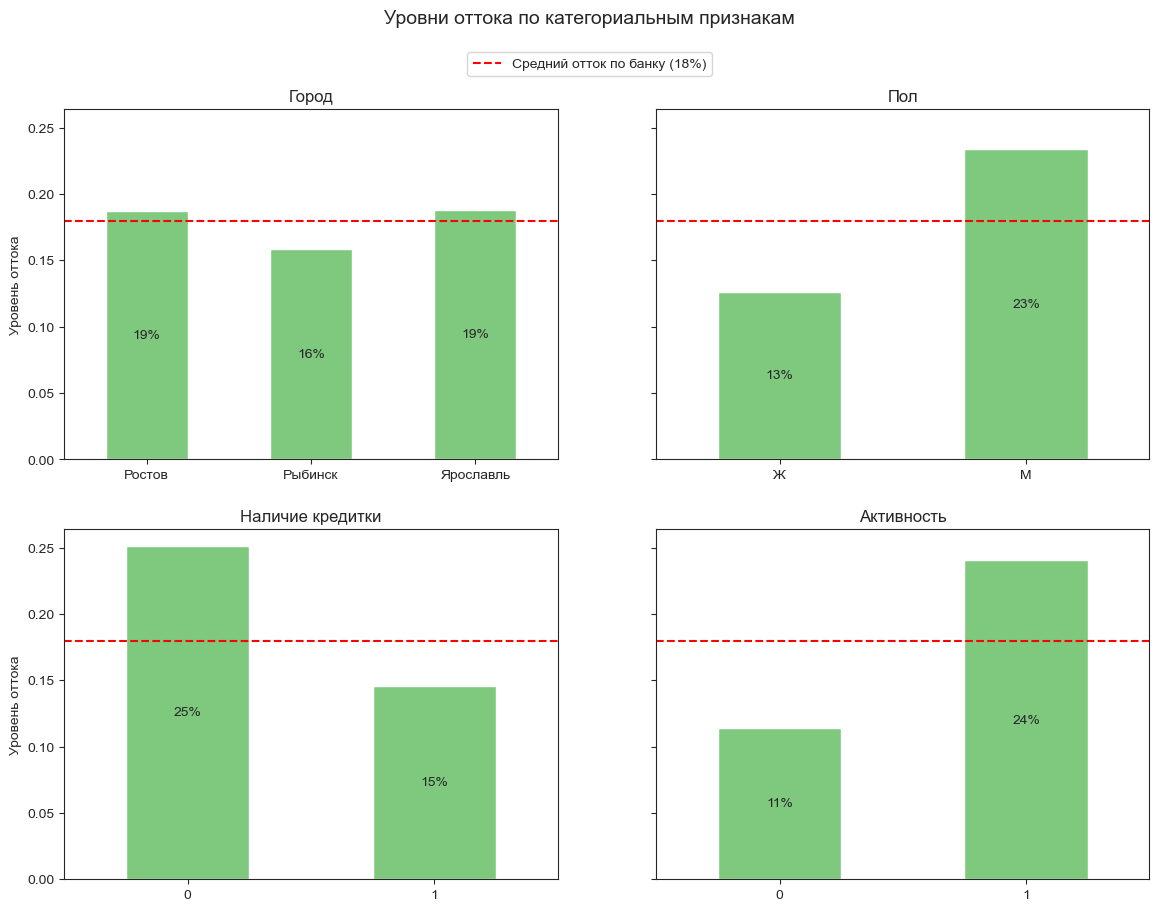

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharey=True)
plt.suptitle('Уровни оттока по категориальным признакам', fontsize=14)

bar_cols = ['city', 'gender', 'credit_card', 'last_activity']
ax_xlabels = ['Город', 'Пол', 'Наличие кредитки', 'Активность']
mean_churn_line = mlines.Line2D([], [], c='r', ls='--', 
                                label=f'Средний отток по банку ({mean_churn:.0%})')

for i, ax in enumerate(axes.flatten()):
    df.groupby(bar_cols[i])['churn'].mean().plot.bar(rot=0, cmap='Accent', ax=ax)
    ax.axhline(y=mean_churn, ls='--', c='r')
    ax.set_title(ax_xlabels[i])
    ax.set_xlabel(None)
    ax.set_ylabel('Уровень оттока')
    for p in ax.patches:
        h, w, x = p.get_height(), p.get_width(), p.get_x()
        xy = (x + w / 2., h / 2)
        text = f'{h:.0%}'
        ax.annotate(text=text, xy=xy, ha='center', va='center')
        
fig.legend(handles=[mean_churn_line], loc='center', bbox_to_anchor=(0.5, 0.925));

По всем признакам есть различия.

- У клиентов, проявлявших активность за последний месяц, отток в два раза выше, чем у неактивных;
- Значительно повышен отток у клиентов без кредитных карт и у мужчин;
- Немного меньше отточных клиентов в Рыбинске.

Повышенный отток у активных клиентов можно рассмотреть отдельно:
- Активностью в теории могло считаться и обращение в банк с целью закрытия всех продуктов или сообщения о намерении уйти;
- Может свидетельствовать о проблемах с качеством сервиса, например: 
    - Процесс совершения операций сложный или неудобный, что подталкивает активных клиентов к уходу в другие банки;
    - Менее активные клиенты испытывают те же неудобства, но для них это не так критично, так как совершать операции приходится редко.

Признак наличия кредитной карты самый перспективный – можно рекламировать кредитку тем, у кого ее нет, так как среди имеющих ее отток заметно ниже.

#### Количественные признаки

Количественные признаки разделим на две группы:
- С небольшим числом уникальных значений – `equity`, `products`;
- Непрерывные (`balance`, `salary`) и дискретные с большим числом значений (`score`, `age`).

Для первой группы посмотрим на процент оттока при каждом значении, делая поправки на число пользователей, по которому он рассчитывается. Для второй построим гистограммы в разрезе оттока и сравним распределения.

Начнем с первой группы. Рассмотрим признак числа баллов собственности (от 0 до 9). Сначала проверим размер данных в каждом значении.

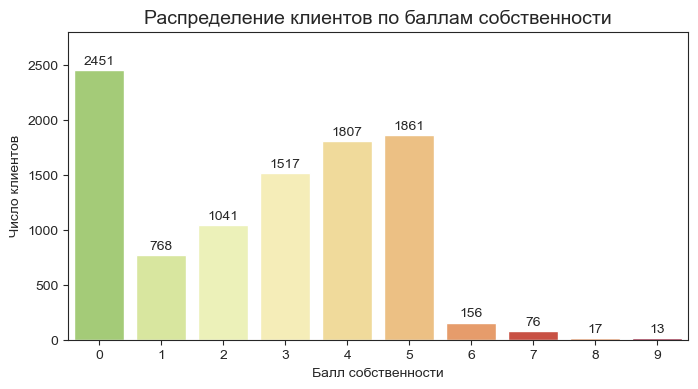

In [50]:
churn_by_equity = df.groupby('equity').agg({'churn':'mean', 'user_id':'count'})

norm = plt.Normalize(mean_churn - (churn_by_equity['churn'].max() - mean_churn), 
                    churn_by_equity['churn'].max())
colors = plt.cm.RdYlGn_r(churn_by_equity['churn'].apply(norm))

plt.figure(figsize=(8,4))
plt.ylim(0,2800)
plt.title('Распределение клиентов по баллам собственности', fontsize=14)
ax = sns.barplot(data=churn_by_equity.reset_index(), x='equity', y='user_id', palette=colors);
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h + 25)
    text = f'{int(h)}'
    ax.annotate(text=text, xy=xy, ha='center', va='bottom')
plt.xlabel('Балл собственности')
plt.ylabel('Число клиентов');

Распределение интересное.

Выбивающийся пик на нуле баллов собственности может включать в себя тех клиентов, которые не предоставляли банку данные о своем имуществе – для многих продуктов эта информация не требуется, а пропущенных значений в столбце нет.

Делать отдельные выводы о клиентах с баллом 6 и выше некорректно – их слишком мало по отношению к другим значениям.

In [51]:
print(f'Число клиентов с 6 и более баллов собственности: {churn_by_equity.loc[6:, "user_id"].sum()}')

Число клиентов с 6 и более баллов собственности: 262


Построим тепловую карту по уровню оттока для каждого балла собственности, объединив клиентов с 6 баллами и выше в одну группу.

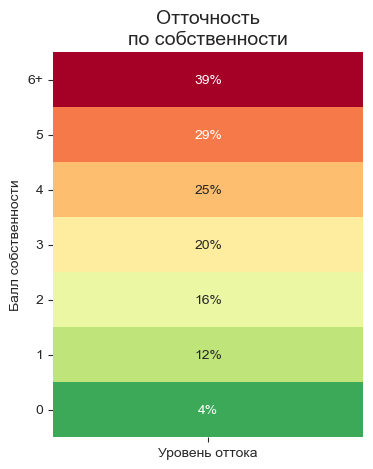

In [52]:
plt.figure(figsize=(4,5))
plt.title('Отточность\nпо собственности', fontsize=14)
ax = sns.heatmap(data=pd.DataFrame(pd.concat([df['equity'].mask(df['equity'] > 5, '6+'), 
                                  df['churn']], axis=1)
                       .groupby('equity')['churn'].mean()), 
                 cmap='RdYlGn_r', center=mean_churn, annot=True, fmt='.0%', cbar=False,
                 xticklabels=['Уровень оттока'])
ax.invert_yaxis()
plt.ylabel('Балл собственности')
plt.yticks(rotation=0);

Чем выше балл собственности, тем больше отточных клиентов. Можно с уверенностью сказать, что признак связан с уровнем оттока.

- На уровне от 0 до 2 баллов процент отточных ниже, чем в среднем по банку, на 3-х баллах – чуть выше.
- У клиентов с 4 или 5 баллами заметно повышен, у микрогруппы с 6 баллами и больше – высокий.

Таким же образом рассмотрим признак числа продуктов, которыми пользуется клиент. Сначала проверим численность групп для каждого значения.

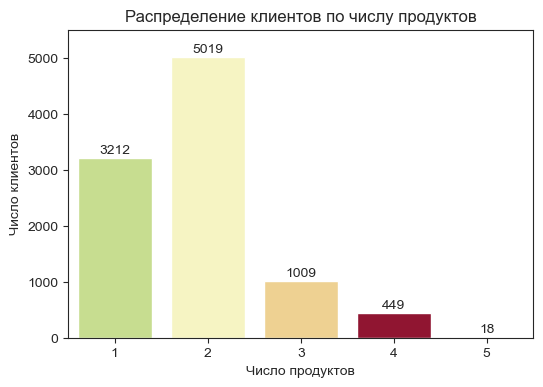

In [53]:
churn_by_products = df.groupby('products').agg({'churn':'mean', 'user_id':'count'})

norm = plt.Normalize(mean_churn - (churn_by_products['churn'].max() - mean_churn), 
                    churn_by_products['churn'].max())
colors = plt.cm.RdYlGn_r(churn_by_products['churn'].apply(norm))

plt.figure(figsize=(6,4))
plt.ylim(0,5500)
plt.title('Распределение клиентов по числу продуктов', fontsize=12)
ax = sns.barplot(data=churn_by_products.reset_index(), x='products', y='user_id', palette=colors);
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h + 25)
    text = f'{int(h)}'
    ax.annotate(text=text, xy=xy, ha='center', va='bottom')
plt.xlabel('Число продуктов')
plt.ylabel('Число клиентов');

Большинство клиентов имеет 1-2 продукта. Максимальное число продуктов – 5, число таких клиентов исчезающе мало. Присоединим их к клиентам с 4 баллами и построим тепловую карту по уровням оттока.

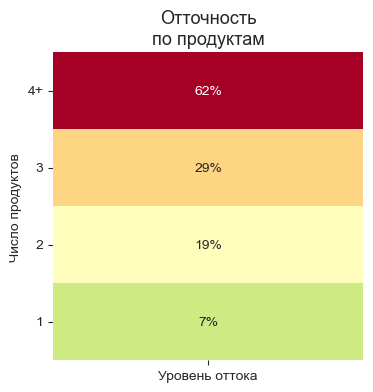

In [54]:
plt.figure(figsize=(4,4))
plt.title('Отточность\nпо продуктам', fontsize=13)
ax = sns.heatmap(data=pd.DataFrame(pd.concat([df['products'].mask(df['products'] > 3, '4+'), 
                                              df['churn']], axis=1)
                                   .groupby('products')['churn'].mean()), 
                 cmap='RdYlGn_r', center=mean_churn, annot=True, fmt='.0%', cbar=False,
                 xticklabels=['Уровень оттока'])
ax.invert_yaxis()
plt.ylabel('Число продуктов')
plt.yticks(rotation=0);

У клиентов с 4 продуктами и более отток крайне высокий – 62%. У имеющих 3 продукта заметно повышен, на 2 продуктах чуть выше среднего.

Перейдем к признакам, в которых много уникальных значений. Построим гистограммы распределения и нанесем на них линии плотности в разбивке по отточности.
<a id='kdeplots'></a>

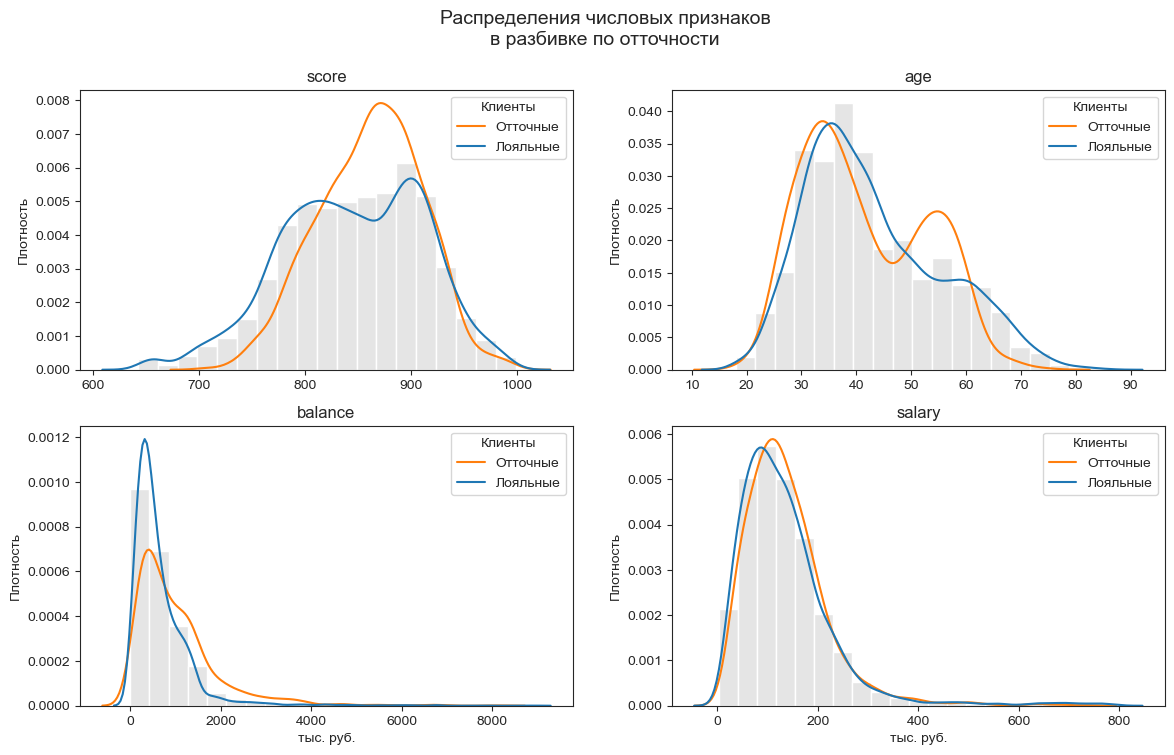

In [95]:
dist_cols = ['score', 'age', 'balance', 'salary']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
fig.suptitle('Распределения числовых признаков\nв разбивке по отточности', fontsize=14);

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=df, x=dist_cols[i], hue='churn', common_norm=False, ax=ax)
    sns.histplot(data=df, x=dist_cols[i], stat='density', bins='doane', 
                 color='grey', alpha=0.2, ax=ax);
    ax.set_title(dist_cols[i])
    ax.set_ylabel('Плотность')
    ax.legend(title='Клиенты', labels=['Отточные', 'Лояльные'])
    if i in [2,3]:
        ax.set_xlabel('тыс. руб.')
    else:
        ax.set_xlabel(None)

Заметны диапазоны значений, которые чаще встречаются у отточных клиентов.

По признакам можно выделить отточные и неотточные категории:
- `score`:
    - повышенный отток – от 820 до 900 баллов;
    - пониженный отток – до 820 баллов;
- `age`:
    - повышенный отток – от 50 до 60 лет;
    - пониженный отток – от 35 до 49 лет и от 60 лет;
- `balance`:
    - повышенный отток – от 750 тыс. рублей;
    - пониженный отток – до 750 тыс. рублей;
- `salary`:
    - повышенный отток – от 100 до 225 тыс. рублей;
    - пониженный отток – до 100 тыс. рублей.

Чтобы посмотреть, насколько различаются проценты оттока в выделенных группах, добавим столбцы с категоризацией этих признаков и рассчитаем процент оттока по каждой группе.

In [56]:
# создаем категоризацию признаков
df.insert(2, 'score_bin', pd.cut(df['score'], 
                                 bins = [0, 819, 900, df['score'].max()], 
                                 labels = ['< 820', '820-900', '> 900']))
df.insert(6, 'age_bin', pd.cut(df['age'], 
                               bins = [0, 34, 49, 60, df['age'].max()], 
                               labels = ['< 35', '35-49', '50-60', '60+']))
df.insert(9, 'balance_bin', pd.cut(df['balance'], 
                                   bins = [df['balance'].min()-1, 749, df['balance'].max()], 
                                   labels = ['< 750', '750+']))
df.insert(14, 'salary_bin', pd.cut(df['salary'], 
                                   bins = [df['salary'].min()-1, 99, 225, df['salary'].max()], 
                                   labels = ['< 100', '100-225', '225+']))

In [57]:
# считаем средний отток по каждой группе
for col in dist_cols:
    display(pd.DataFrame(df.groupby(col+'_bin').agg({'churn':'mean', 'user_id':'count'})))

,churn,user_id
score_bin,,
< 820,0.11,3283
820-900,0.24,4138
> 900,0.17,2286


,churn,user_id
age_bin,,
< 35,0.21,2826
35-49,0.15,4136
50-60,0.26,1729
60+,0.06,1013


,churn,user_id
balance_bin,,
< 750,0.17,4940
750+,0.34,2609


,churn,user_id
salary_bin,,
< 100,0.16,3835
100-225,0.20,4781
225+,0.17,1091


Повышенные уровни оттока есть в диапазонах по всем признакам:
- Баланс от 750 тыс. – 34%;
- Возраст: 
    - 50-60 лет – 26%;
    - до 35 лет – 21%;
- Балл кредитного скоринга от 820 до 900 – 24%;
- Зарплата от 100 до 225 тыс. – 20%.

<a id='profiles'></a>
### Портрет отточного и лояльного клиента

Попробуем охарактеризовать типичного отточного клиента и сравнить его с типичным лояльным. Для этого рассчитаем для них средние значения по всем признакам.

In [58]:
profiles = df.groupby('churn').agg({'user_id':'count',
                                    'score':'mean',
                                    'age':'median',
                                    'equity':'mean',
                                    'balance':'median',
                                    'salary':'median',
                                    'products':'mean',
                                    'credit_card':'mean',
                                    'last_activity':'mean',
                                    'is_female':'mean'}).T
profiles['pct_diff'] = abs(profiles[1]-profiles[0]) / ((profiles[0]+profiles[1]) / 2) * 100
profiles.drop('user_id').sort_values(by='pct_diff', ascending=False)

churn,0,1,pct_diff
balance,472.53,770.77,47.98
equity,2.40,3.75,43.86
is_female,0.53,0.35,41.31
last_activity,0.48,0.70,36.29
products,1.76,2.37,29.39
credit_card,0.71,0.55,24.73
salary,116.88,123.82,5.77
age,40.00,39.00,2.53
score,844.89,861.93,2.00


Самая большая разница в балансе – медианные значения различаются на 48%, у отточных больше средств на счете.

Отличие по баллам собственности на втором месте с разницей в 44% (на значение может влиять большое число клиентов с нулем баллов – возможно, для части из них ноль означает отсутствие информации о собственности).

Портрет отточного клиента:
- Пол – чаще **мужчина** (65%);
- Возраст – 39 лет;
- Баланс на счете – около **770** тыс.;
- Баллов собственности – в среднем 3.8;
- Продуктов – в среднем 2.4;
- Была **активность** в последнем месяце (70%);
- Зарплата – 124 тыс.;
- Балл кредитного скоринга – 862.

Портрет лояльного клиента:
- Возраст – 40 лет;
- Баланс на счете – около **473** тыс.;
- Баллов собственности – в среднем 2.4;
- Продуктов – в среднем 1.8;
- **Имеет кредитную карту** (70%);
- Зарплата – 117 тыс.;
- Балл кредитного скоринга – 845.

<a id='corr'></a>
### Корреляционный анализ

По анализу отдельных признаков мы поняли, какие из них могут быть связаны с оттоком. Проверим сделанные предположения с помощью рассчета корреляции.

In [59]:
# создадим отдельный датасет для корреляции phik, исключив ненужные столбцы
df_corr = df.drop(['user_id', 'score_bin', 'age_bin', 'salary_bin', 'balance_bin', 
                  'Ростов', 'Рыбинск', 'Ярославль', 'is_female'], axis=1)

# создадим словарь названий признаков для отображения на графиках
rulabels = {'equity':'Собственность',
           'balance':'Баланс',
           'products':'Продукты',
           'last_activity':'Активность',
           'score':'Скоринг',
           'gender':'Пол',
           'credit_card':'Кредитка',
           'age':'Возраст',
           'salary':'Зарплата',
           'city':'Город',
           'Ярославль':'Город:\nЯрославль',
           'Ростов':'Город:\nРостов',
           'Рыбинск':'Город:\nРыбинск',
           'is_female':'Пол (женский)'}

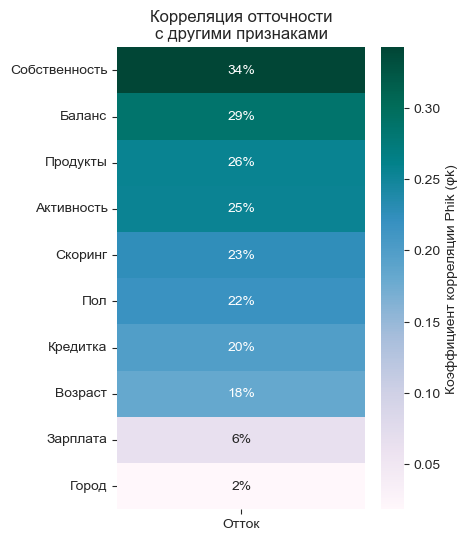

In [60]:
# строим табличную матрицу корреляций по всем признакам
phik_matrix = (
    df_corr.phik_matrix(interval_cols=['score', 'age', 'equity', 'balance', 'products', 'salary'])
)
# берем из матрицы корреляцию оттока
phik_churn = pd.DataFrame(phik_matrix['churn'].drop('churn').sort_values(ascending=False))

# строим тепловую карту
plt.figure(figsize=(4,6))
plt.title('Корреляция отточности\nс другими признаками')
sns.heatmap(data=phik_churn, cmap='PuBuGn', annot=True, fmt='.0%',
           yticklabels=[rulabels[i] for i in phik_churn.index],
           xticklabels=['Отток'],
           cbar_kws={'label': 'Коэффициент корреляции Phik (φk)'});

По шкале Чеддока значение коэффициента ниже 0.1, или 10%, означает практическое отсутствие связи. Такой низкий результат получили признаки зарплаты и города.

По остальным признакам корреляция обнаружена. Самая сильная связь – с числом баллов собственности, 34%. Только ее можно назвать умеренной. 

Признаки, имеющие слабую связь:
- Баланс – 29%
- Число продуктов – 26%
- Активность в последнем месяце – 25%
- Балл кредитного скоринга – 23%
- Пол клиента – 22%
- Наличие кредитной карты – 20%
- Возраст – 18%

Коэффициент PhiK не отражает направление связи (отрицательная или положительная), только ее наличие. Он также способен обнаруживать нелинейные зависимости.

Также рассчитаем коэффициент корреляции по методу Спирмена.

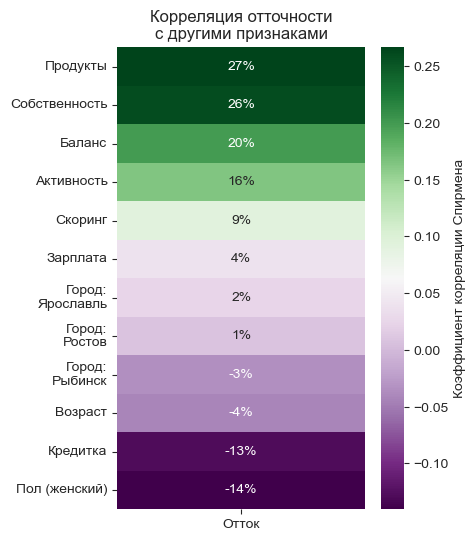

In [61]:
spm_churn = pd.DataFrame(
    df.drop('user_id', axis=1).corr(method='spearman')['churn']
    .drop('churn').sort_values(ascending=False)
)
# строим тепловую карту
plt.figure(figsize=(4,6))
plt.title('Корреляция отточности\nс другими признаками')
sns.heatmap(data=spm_churn, cmap='PRGn', annot=True, fmt='.0%',
           yticklabels=[rulabels[i] for i in spm_churn.index],
           xticklabels=['Отток'],
           cbar_kws={'label': 'Коэффициент корреляции Спирмена'});

Здесь также отсутствует значимая связь между городами и зарплатой. 

С баллом кредитного скоринга и возрастом зависимость не монотоническая, поэтому Спирмен по этим признакам показал практическое отсутствие корреляции, хотя она есть.

По всем остальным признакам и этот метод обнаружил слабую связь. Порядок признаков тоже похожий:
- Выше всего связь с числом продуктов, баллами собственности, балансом;
- Меньше – с активностью, полом, наличием кредитки.

Направление связи подтверждает сделанные ранее наблюдения:
- Отрицательная для женского пола и наличия кредитной карты – больше оттока у мужчин и не имеющих кредитки;
- Положительная (больше оттока при более высоких значениях) для всех остальных признаков, где обнаружена значимая связь.

Также исследуем связь признаков между собой, чтобы ориентироваться на пересечения групп с повышенным оттоком при сегментации.
<a id='cond_corr'></a>

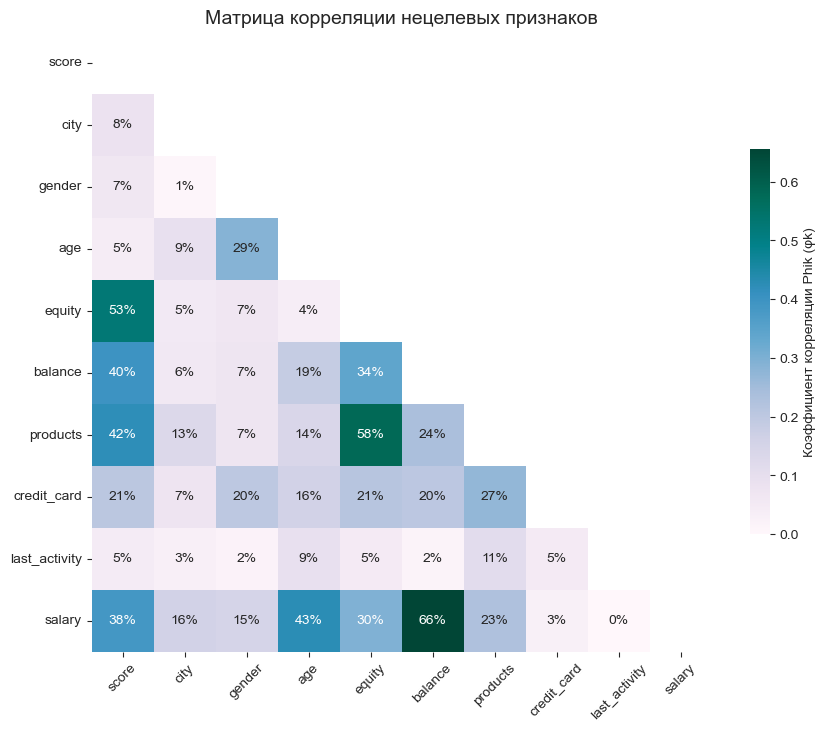

In [62]:
phik_drop_churn = phik_matrix.drop('churn', axis=1).drop('churn')
mask = np.triu(np.ones_like(phik_drop_churn))

plt.figure(figsize=(10,10))
plt.title('Матрица корреляции нецелевых признаков', fontsize=14)
sns.heatmap(data=phik_drop_churn, mask=mask,
           square=True, annot=True, fmt='.0%', cmap='PuBuGn',
           cbar_kws={'shrink':0.5, 'label':'Коэффициент корреляции Phik (φk)'});
plt.xticks(rotation=45);

Некоторые признаки коррелируют друг с другом – значит, при совместной фильтрации данных по ним размер сегмента не так сильно уменьшится при добавлении новых условий (для монотонически распределенных значений).

- Заметная связь:
    - Зарплата с балансом – 66%;
    - Собственность с продуктами – 58%;
    - Собственность с баллом кредитного скоринга – 53%;
- Умеренная связь:
    - Зарплата с возрастом – 43%;
    - Продукты с баллом кредитного скоринга – 42%;
    - Зарплата с баллом кредитного скоринга – 38%;
    - Собственность с балансом – 34%;
    - Собственность с зарплатой – 30%;
- Из слабых связей интересные:
    - Пол с возрастом – 29%;
    - Наличие кредитки связано со всеми признаками, кроме активности, зарплаты и города;
    - Город с зарплатой и продуктами;
    - Активность почти ни с чем не связана.


### Выводы по исследовательскому анализу

В ходе исследовательского анализа мы изучили все признаки клиентов на предмет связи с повышенной отточностью. Для этого применяли разные методы:
- Расчет коэффициента корреляции (основной метод phik, дополнительно Спирмен);
- Построение графиков распределения значений с разделением по отточности, чтобы обнаружить нелинейные зависимости;
- Сравнение средних значений для отточных и лояльных клиентов;
- Расчет процента оттока в группировке по признакам.

Подведем итоги проведенной работы и опишем, каким образом каждый признак связан (или не связан) с уровнем оттока клиентов.

Средний уровень оттока по банку – 18%.
<a id='eda_concl'></a>

| Признак | Корреляция (phik) | Значения с повышенным оттоком | Среднее значение для отточных | Среднее значение для лояльных | Разница средних | Комментарии |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Число баллов собственности<br>(`equity`) | 34% | 6-9 баллов – 39%<br>4-5 баллов – 25-29%<br>3 балла – 20% | среднее 3.75, медиана 4<br> | среднее 2.4, медиана 2 | 34% | Очень много клиентов с нулем баллов собственности – в это значение могут входить клиенты, которые не предоставляли банку информацию об имуществе. |
| Баланс на счете<br>(`balance`) | 29% | от 750 тыс. – 34% | медиана 771 тыс. | медиана 473 тыс. | 48% | В исходных данных по признаку [отсутствует 23% значений](#nans), пропуски не случайны (MNAR). |
| Число продуктов<br>(`products`) | 26% | 4-5 продуктов – 62%<br>3 продукта – 29%<br>2 продукта – 19% | среднее 2.4 | среднее 1.8 | 29% | – |
| Активность в последнем месяце<br>(`last_activity`) | 25% | Наличие активности – 24% | 70% активных | 48% активных | 36% | Активностью может считаться и заявление об уходе из банка. Повышенный отток среди активных может свидетельствовать о недостатках сервиса. |
| Балл кредитного скоринга<br>(`score`) | 23% | 820-900 баллов – 24% | среднее 862 | среднее 845 | 2% | Пропуски в столбце баланса при высоких и низких значениях. |
| Пол<br>(`gender`) | 22% | Мужской пол – 25% | 65% мужчины | 47% мужчины | 41% | – |
| Наличие кредитной карты<br>(`credit_card`) | 20% | Отсутствие кредитки – 25% | 55% имеют кредитку | 71% имеют кредитку | 25% | – |
| Возраст<br>(`age`) | 18% | 50-60 – 26%<br>до 35 – 21% | медиана 39 | медиана 40 | 3% | В исходных данных по признаку [отсутствует 3% значений](#nans), пропуски не случайны (MNAR). |
| Зарплата<br>(`salary`) | 6% | 100-225 тыс. – 20% | медиана 124 тыс. | медиана 117 тыс. | 6% | – |
| Город<br>(`city`) | 2% | Ярославль и Ростов – 19% | – | – | – | В Рыбинске отток 16%. |

Почти все признаки имеют явные значения или диапазоны, в которых уровень оттока заметно выше.

Только два признака по коэффициенту корреляции практически не связаны с отточностью – зарплата и город. В категориях с более высоким оттокам он составляет 19-20%, всего на 1% выше среднего по банку. Для полной уверенности проверим разницу между уровнями оттока по этим признакам статистическими критериями.

<a id='stattest'></a>
## Проверка статистических гипотез

Проверим на связь с отточностью те признаки, для которых предыдущие методы не обнаружили значимой корреляции – это зарплата (`salary`, отток повышен на 2% от среднего по банку) и город (`city`, отток повышен на 1%) клиентов.

Применим для них подходящие методы:
- `salary`
    - t-критерий Стьюдента;
    - U-критерий Манна-Уитни;
- `city`
    - Критерий хи-квадрат.
    
Подробнее используемые методы опишем в соответствующих разделах.

### Равенство зарплат отточных и лояльных

Признак зарплаты проверим сразу двумя методами. Они предназначены для проверки разных гипотез: t-критерий проверяет на равенство средних, а U-критерий – на равенство распределений.

Рассмотрим особенности применения каждого критерия для анализа признака `salary`.

**t-критерий Стьюдента**:

>Проверяет на равенство средних. Обычно требует нормального распределения, потому что создавался для маленьких выборок (меньше 30 наблюдений в каждой группе).

>[Распределение зарплат](#kdeplots) смещено влево, однако размер наших групп намного больше. Согласно ЦПТ, если наблюдений в выборке больше 30-50, то выборочные средние будут распределены нормально вокруг среднего генеральной совокупности. Критерий Стьюдента может сработать и для ненормально распределенного признака, если данных много. 

**U-критерий Манна-Уитни**, или критерий знаковых рангов Уилкоксона:

>Присваивает ранг каждому значению совмещенных групп, поэтому не требует нормального распределения значений. Далее в тесте используются именно эти ранги, медианы или средние не рассчитываются. 

>Тест покажет положительный результат, если в одной из групп значения в целом получают более высокие ранги – следовательно, эти выборки не могут принадлежать к одному и тому же распределению общей генеральной совокупности; распределения групп не одинаковы. 

>Если распределения групп очень похожи по форме, то при наличии значимой разницы одно из них просто будет сдвинуто по оси x. Именно такую ситуацию наблюдаем на [графике плотности](#kdeplots) зарплат. В таком случае разница между распределениями будет также говорить о разнице медианных значений между группами – куда сдвинуто распределение, туда и его медиана.

Таким образом, при сравнении зарплат отточных и лояльных клиентов можно рассматривать t-критерий как тест на равенство средних, а U-критерий – как тест на равенство медиан.

Медианы более точно характеризуют группы, ведь в столбце зарплаты достаточно много крайне высоких значений, которые могут сместить средние.

Большинство требований к данным для проведения этих тестов сопадают, и наши данные подходят по следующим параметрам:
- Выборки случайны и независимы друг от друга (один элемент не может принадлежать обеим группам);
- Данные непрерывные.

Критерий Стьюдента также требует примерно нормального распределения и похожей дисперсии в обоих группах. Требование к распределению не удовлетворяется, поэтому результаты могут быть неточными, несмотря на большое число данных в выборке. Для проверки проведем t-test два раза – сначала на всем диапазоне данных, затем полностью исключим выбросы (возьмем только ту часть данных, которая распределена нормально).

Перед тестом сравним дисперсии групп: если отношение большей к меньшей не превышает 4, можно считать их равными.

In [63]:
df.groupby('churn')['salary'].describe()['std']**2

churn
0   9504.01
1   6879.12
Name: std, dtype: float64

Отличие дисперсий не критично, можем считать их приблизительно одинаковыми.

#### Равенство средних:  t-test

Проверим на равенство средние арифметические для столбца `salary` в разбивке по отточности с помощью t-критерия Стьюдента.

Сформулируем нулевую и альтернативную гипотезы:

- H<sub>0</sub>: средние зарплаты отточных и лояльных клиентов равны
- H<sub>1</sub>: средние зарплаты отточных и лояльных клиентов отличаются

In [67]:
# разделим данные зарплат по оттоку
salary_loyal = df.loc[df['churn'] == 0, 'salary']
salary_churn = df.loc[df['churn'] == 1, 'salary']

# критический уровень статистической значимости – 5% достаточно
alpha = 0.05

# функция для отображения результатов теста
def tt_result(sample1, sample2, alpha=alpha):
    t, p = st.ttest_ind(sample1, sample2)
    m1, m2 = sample1.mean(), sample2.mean()
    diff = abs(m2-m1) / ((m2+m1) / 2)
    print(f'Среднее лояльной группы: {round(m1, 2)}')
    print(f'Среднее отточной группы: {round(m2, 2)}')
    print(f'Разница: {diff:.0%}')
    print(f'p-value: {round(p, 5)}')
    print(f'alpha: {alpha}')
    if p < alpha:
        print('Есть основания отвергнуть нулевую гипотезу.')
    else:
        print('Нет оснований отвергать нулевую гипотезу.')

Проведем первый тест – по всем данным зарплаты, включая хвост распределения.

In [69]:
tt_result(salary_loyal, salary_churn, alpha=alpha)

Среднее лояльной группы: 135.1
Среднее отточной группы: 137.65
Разница: 2%
p-value: 0.30901
alpha: 0.05
Нет оснований отвергать нулевую гипотезу.


Если учитывать самые высокие зарплаты в данных, то разница между средними незначительна. Значение p-value довольно высоко.

Проверим, как хвост распределения влияет на средние. По [графику плотности](#kdeplots) приблизительно нормальные распределения в обоих группах мы получим, если ограничить выборку зарплатами до 300 тыс. Проведем повторный тест по данным с отрезанным хвостом.

In [70]:
tt_result(salary_loyal[salary_loyal <= 300], 
          salary_churn[salary_churn <= 300], alpha=alpha)

Среднее лояльной группы: 120.52
Среднее отточной группы: 126.83
Разница: 5%
p-value: 0.0002
alpha: 0.05
Есть основания отвергнуть нулевую гипотезу.


Если полностью исключить выбросы и взять только самые частотные значения, то разница средних зарплат окажется статистически значимой. Значение p-value говорит о том, что вероятность случайно получить такую выборку при верной нулевой гипотезе намного меньше даже 1%.

#### Равенство распределений:  U-test

Проверим распределение значений зарплат у отточных и лояльных клиентов с помощью критерия знаковых рангов Уилкоксона.

Сформулируем нулевую и альтернативную гипотезы:

- H<sub>0</sub>: распределение зарплат у отточных и лояльных клиентов одинаково
- H<sub>1</sub>: распределение зарплат у отточных и лояльных клиентов отличается

In [71]:
# функция для отображения результатов теста
def wmw_result(sample1, sample2, alpha=alpha):
    u, p = st.mannwhitneyu(sample1, sample2)
    md1, md2 = sample1.median(), sample2.median()
    diff = abs(md2-md1) / ((md2+md1) / 2)
    print(f'Медиана лояльной группы: {md1}')
    print(f'Медиана отточной группы: {md2}')
    print(f'Разница: {diff:.0%}')
    print(f'p-value: {p.round(5)}')
    print(f'alpha: {alpha}')
    if p < alpha:
        print('Есть основания отвергнуть нулевую гипотезу.')
    else:
        print('Нет оснований отвергать нулевую гипотезу.')

In [72]:
wmw_result(salary_loyal, salary_churn, alpha=alpha)

Медиана лояльной группы: 116.875125
Медиана отточной группы: 123.82334
Разница: 6%
p-value: 0.0002
alpha: 0.05
Есть основания отвергнуть нулевую гипотезу.


U-test обнаружил значимую разницу между распределениями зарплат. Значение p-value здесь снова крайне низкое, уверенность в результате высокая.

**Выводы по проверке гипотез о равенстве зарплат**

Первая нулевая гипотеза: средние зарплаты у отточных и лояльных клиентов равны.

Результат t-критерия показал отсутствие разницы между средними групп. Однако t-test требует нормального распределения, а наши данные под него не подходят – на результат теста мог повлиять тонкий хвост распределения. Если отрезать его от данных, получится нормальное распределение, и на этом диапазоне данных статистический критерий нашел значимое различие между группами, причем с высокой степенью уверенности.

Сранивать средние при наличии экстремальных значений некорректно даже без стат. теста. К тому же, [на графике](#kdeplots) видно, что разница в распределениях зарплат на крайне высоких значениях исчезает – это вызывает дополнительные смещения средних для групп, делая их сравнение еще менее показательным.

Исходя из этого, доверять результатам теста t-критерием следует с осторожностью.

Вторая нулевая гипотеза: распределения зарплат у отточных и лояльных клиентов одинаковы.

Критерий Манна-Уитни показал наличие статистически значимой разницы между распределениями. Нулевая гипотеза с высокой степенью уверенности может быть отвергнута. 

### Равенство оттока по городам

Города проверим через критерий хи-квадрат на независимость переменных. Тест поможет определить, есть ли связь между распределением клиентов по отточности и городом.

Для его применения нужна сводная таблица, где по одной оси признак отточности, по другой города, а в ячейках число клиентов на каждом пересечении значений признаков. Тест проверяет, насколько значения в ячейках отличаются от тех, которые получились бы при расчетах по всем данным сразу – то есть, если значения в столбцах не имели бы никакого влияния.

Данные подходят под все требования теста:
- Обе переменные (отточность и город) категориальные;
- Наблюдения независимые (не пересекаются), каждое наблюдение может учитываться только в одной ячейке таблицы;
- По числу наблюдений в ячейках – данных более чем достаточно.

Сформулируем гипотезы:

- H<sub>0</sub>: доли отточных клиентов по городам не отличаются
- H<sub>1</sub>: доли отточных клиентов по городам разные

Составим сводную таблицу по отточности и городам.

In [73]:
rxc_table = pd.crosstab(df.churn, df.city)
rxc_table

city,Ростов,Рыбинск,Ярославль
churn,,,
0,1151,2201,4610
1,265,414,1066


Получили число лояльных и отточных клиентов в каждом городе. С помощью теста сравним, можно ли считать доли отточности одинаковыми.

In [74]:
stat, p, dof, exp_fs = st.chi2_contingency(rxc_table)
print(f'p-value: {p.round(5)}')
print(f'alpha: {alpha}')
if p < alpha:
    print('Есть основания отвергнуть нулевую гипотезу.')
else:
    print('Нет оснований отвергать нулевую гипотезу.')

p-value: 0.00375
alpha: 0.05
Есть основания отвергнуть нулевую гипотезу.


Тест нашел значимые различия в долях. Город тоже можно считать признаком, связанным с повышенной отточностью.

**Выводы по гипотезе о связи города с отточностью**

Тест хи-квадрат на независимость переменных показал, что город все же связан с повышенным оттоком: есть разница между распределением по отточности внутри городов. Значение p-value намного ниже уровня статистической значимости, уверенность в результате высокая.

Нулевую гипотезу можно отвергнуть.

### Выводы по проверке статистических гипотез

В разделе мы проверили два признака, которые на предыдущих этапах исследования показали крайне низкое влияние на уровень оттока. При группировке по признаку зарплаты самый высокий уровень оттока составил 20%, по городам – 19%. Это всего на 1-2% ниже среднего показателя по банку (18%).

По проверке можно сделать вывод о том, что оба признака все же связаны с оттоком – статистические критерии не позволяют считать, что тестируемые характеристики у групп одинаковые.

<a id='segmentation'></a>
## Сегментация по стратегическим признакам

Для всех признаков в датасете можно выделить категории, в которых уровень оттока выше среднего по банку (см. [таблицу признаков](#eda_concl)), но не все из них одинаково подходят для выделения сегментов.

### Определение значимых признаков
<a id='products_activity'></a>

Лучшие признаки способны образовать компактный сегмент с максимальным процентом отточности, а также охарактеризовать клиента – так будет легче подобрать маркетинговый ход или продукт, который пользуется популярностью именно у этой категории людей. Рассмотрим отдельно два признака, которые к этой категории не относятся – число продуктов (`products`) и активность (`last_activity`).

Два контринтуитивных факта:
- Чем больше у клиента продуктов, тем больше он склонен к уходу;
- Среди активных пользователей отток выше.

Эти признаки должны характеризовать самых лояльных клиентов. Если человеку не нравится первый приобретенный продукт, вряд ли он откроет еще несколько в том же банке. На деле же с каждым новым продуктом удовлетворенность сервисом падает – из всех признаков именно число продуктов дает самые высокие уровни оттока ([4 продукта – отточность 63%](#categorical), 4 продукта и отсутствие активности – 92%).

Такая же логика должна работать и для активных клиентов: если они активно пользуются своими продуктами, то должны образовывать более лояльную группу, чем неактивные (тем их продукты могут быть не нужны). 

В реальности ситуация обратная – [активные клиенты уходят чаще](#categorical), но есть одно интересное исключение. Только для клиентов с большим числом продуктов отток выше у неактивных. В группировке по любому другому признаку более высокий отток дают активные клиенты.

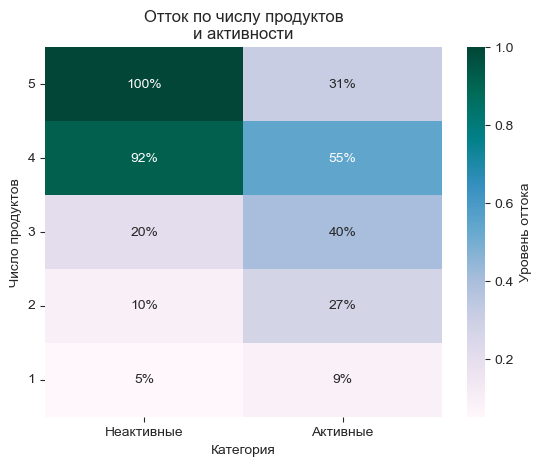

In [75]:
products_activity = (
    df.pivot_table(index='products', columns='last_activity', 
                   aggfunc={'churn':'mean'})
)

ax = sns.heatmap(products_activity, cmap='PuBuGn', annot=True, fmt='.0%',
                 xticklabels=['Неактивные', 'Активные'],
                 cbar_kws={'label':'Уровень оттока'})
plt.title('Отток по числу продуктов\nи активности')
ax.invert_yaxis()
plt.yticks(rotation=0)
plt.xlabel('Категория')
plt.ylabel('Число продуктов');

Другая особенность признака продуктов связана с кредитными картами: в любых других группировках [у клиентов без кредитки отток выше](#categorical), но при высоком числе продуктов уходят те, у кого она есть.

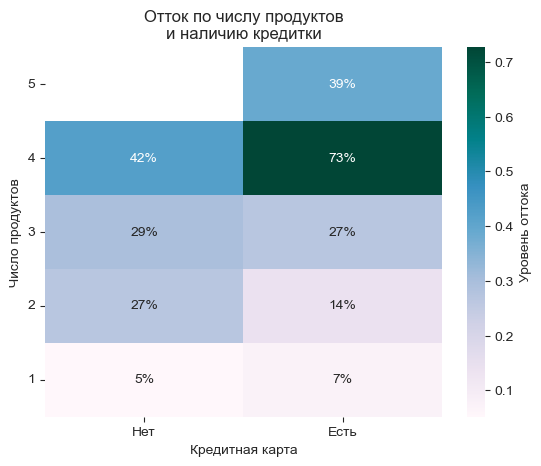

In [76]:
products_cc = (
    df.pivot_table(index='products', columns='credit_card', 
                   aggfunc={'churn':'mean'})
)

ax = sns.heatmap(products_cc, cmap='PuBuGn', annot=True, fmt='.0%',
                 xticklabels=['Нет', 'Есть'],
                 cbar_kws={'label':'Уровень оттока'})
plt.title('Отток по числу продуктов\nи наличию кредитки')
ax.invert_yaxis()
plt.yticks(rotation=0)
plt.xlabel('Кредитная карта')
plt.ylabel('Число продуктов');

Уход клиентов с большим числом продуктов весьма настораживает. Стоит обратить внимание на эту группу и выяснить причину неудовлетворенности банком. 

Отток активных клиентов также может говорить о наличии проблем или неудобств при совершении операций и других действий.
<br>*Другой возможный (но маловероятный) вариант: среди них много клиентов, у которых единственная активность за предыдущий месяц – это закрытие действующих продуктов или сообщение о намерении это сделать. В таком случае наличие активности будет последствием повышенного оттока, а не причиной.*

Главный вывод по признакам `products` и `activity` – этим клиентам нельзя ничего продать:
- Активные и так пользуются имеющимися продуктами и им что-то не нравится; вряд ли они захотят открыть еще один;
- Предлагать новые продукты клиенту, у которых и так их много, мы не хотим – чем больше продуктов, тем выше отток.

Так как цель исследования – в короткий срок и небольшими усилиями поднять отток в банке, при основной сегментации эти признаки учитывать не будем. Их удержание, вероятно, потребует дополнительных исследований и более масштабных усилий – выяснить и устранить причины недовольства сервисом, создать программу лояльности, и т.п.

Сфокусируемся на группах клиентов, которым можно предложить конкретные продукты. Из признаков `products` и `last_activity` составим дополнительные сегменты для отдельного изучения в будущем.

Также откажемся от использования признака города (`city`). Несмотря на то, что статистический тест показал наличие значимой связи с отточностью, по нему можно только исключить один из трех городов (и даже не самый крупный). При этом уровень оттока в оставшихся городах повышен всего на 1% от среднего. Кроме того, мы не можем сделать никаких предположений о предпочтениях или интересах клиентов по их месту жительства. 

### Составление сегментов

Значимые признаки, которые используем в основной сегментации:
- `balance`
- `salary`
- `equity`
- `score`
- `gender`
- `age`
- `credit_card`

Попробуем посмотреть, какой уровень оттока дают различные комбинации этих признаков, с помощью тепловой карты. Сначала составим сводную таблицу, где на пересечении двух признаков найдем размер такого сегмента и процент оттока в нем. Для этого нам нужен список условий по каждому признаку.

In [77]:
s_cond = [
    'balance_bin == "750+"',
    'salary_bin == "100-225"',
    'equity >= 3',
    'score_bin == "820-900"',
    'gender == "М"',
    'age_bin in ["< 35", "50-60"]',
    'credit_card == 0'
]

Создадим функцию для построения сводной таблицы.

In [80]:
def pair_conditions(df, conditions):
    df_s_dict = {}
    
    for i, cond in enumerate(conditions):
        # чтобы таблица получилась треугольной, повторяющиеся пересечения признаков заполним пропусками
        row_pt1 = [(np.nan, np.nan)]*i
        # каждое условие (индексы) совмещаем с каждым из следующих по списку (столбцы) - это строка
        # в ячейках строк для каждой пары признаков запишем размер сегмента и процент оттока
        row_pt2 = [
            (
                len(df.query(cond + ' & ' + cond2)), 
                round(df.query(cond + ' & ' + cond2)['churn'].mean(), 2)
            ) 
        for cond2 in conditions[i:]
        ]
        # добавляем строку в словарь
        df_s_dict[cond] = row_pt1 + row_pt2

    # из словаря строк создаем сводную таблицу, продублировав условия по оси столбцов
    df_s = pd.DataFrame.from_dict(df_s_dict, orient='index', columns=conditions).T
    return df_s

Посмотрим, что получилось.

In [81]:
pair_conditions(df, s_cond)

,"balance_bin == ""750+""","salary_bin == ""100-225""",equity >= 3,"score_bin == ""820-900""","gender == ""М""","age_bin in [""< 35"", ""50-60""]",credit_card == 0
"balance_bin == ""750+""","(2609, 0.34)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
"salary_bin == ""100-225""","(1465, 0.39)","(4781, 0.2)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
equity >= 3,"(2385, 0.35)","(2611, 0.3)","(5447, 0.26)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
"score_bin == ""820-900""","(1235, 0.38)","(2051, 0.27)","(2798, 0.3)","(4138, 0.24)","(nan, nan)","(nan, nan)","(nan, nan)"
"gender == ""М""","(1314, 0.44)","(2478, 0.25)","(2650, 0.35)","(1989, 0.31)","(4841, 0.23)","(nan, nan)","(nan, nan)"
"age_bin in [""< 35"", ""50-60""]","(1096, 0.46)","(1923, 0.27)","(2571, 0.33)","(1993, 0.31)","(2413, 0.27)","(4555, 0.23)","(nan, nan)"
credit_card == 0,"(1172, 0.42)","(1534, 0.29)","(2084, 0.32)","(1546, 0.31)","(1261, 0.34)","(1441, 0.35)","(3117, 0.25)"


Для удобства восприятия отобразим таблицу в виде тепловой карты по уровню оттока. Размер сегмента также отобразим в ячейках, чтобы сразу видеть, какие можно ограничить еще одним признаком, а какие и так слишком мелкие. Для построения графика тоже напишем функцию.

In [82]:
def plot_paired_conditions(df_s, figsize=(15,10)):
    df_s_churn = pd.DataFrame(index=df_s.index)
    df_s_size = pd.DataFrame(index=df_s.index)
    for col in df_s.columns:
        df_s_size[col], df_s_churn[col] = zip(*df_s[col])
    plt.figure(figsize=figsize, tight_layout=True)
    sns.heatmap(data=df_s_churn, annot=df_s, fmt='', cmap='PuBuGn', 
                cbar_kws={'shrink':.5, 'label':'Уровень оттока'});

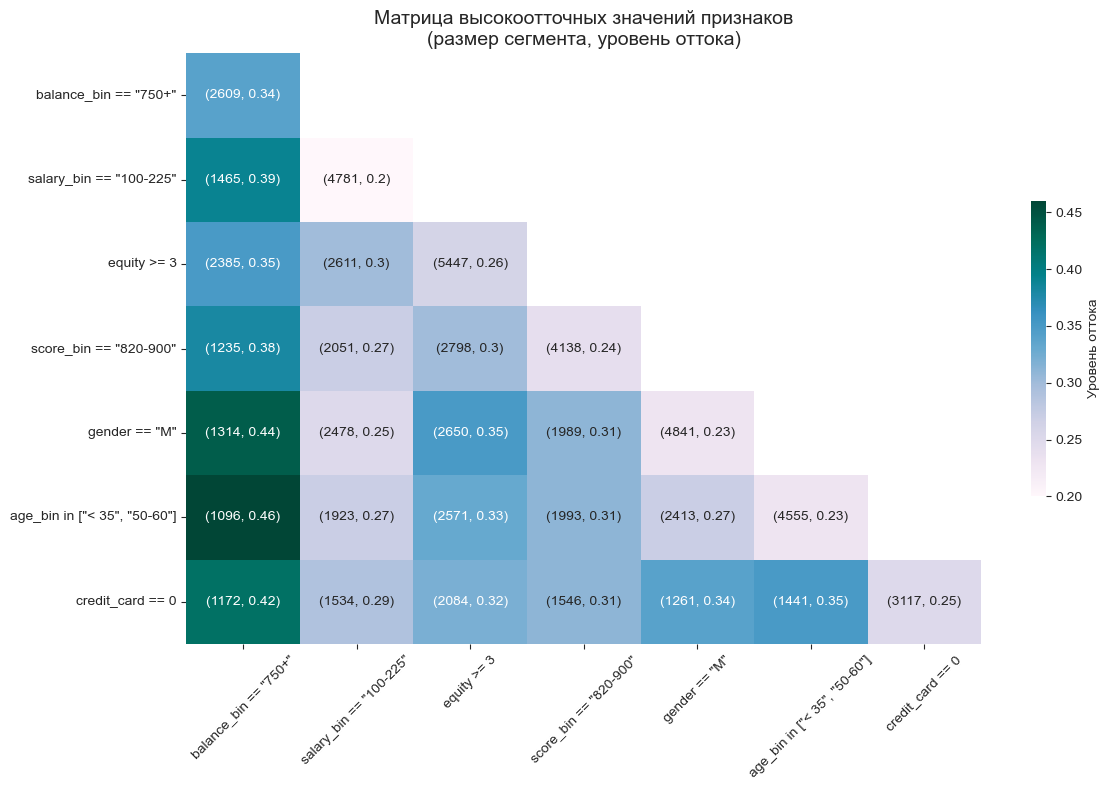

In [83]:
plot_paired_conditions(pair_conditions(df, s_cond), figsize=(12,8))
plt.title('Матрица высокоотточных значений признаков\n(размер сегмента, уровень оттока)', fontsize=14)
plt.xticks(rotation=45);

Самый высокий отток дает баланс, особенно в паре с возрастом, полом и начилием кредитной карты. Сегменты по балансу также самые компактные. Признак зарплаты, напротив, самый низкоотточный – более 30% по нему не получается.

Сгруппируем выделенные признаки на основании типа продукта, который должен быть инетересен определенной аудитории. Выделим их из самых популярных банковских продуктов.

1. **Вклады, накопительные счета, инвестиции**:
    - Баланс на счете от 750 тыс. – сумма для вклада в наличии;
    - Мужской пол – мужчины чаще инвестируют;
    - Возраст – молодые (до 35) инвестируют, старшие взрослые (50-60 лет) открывают вклады и накопительные счета.
    
    
2. **Кредитные карты**:
    - Нет кредитной карты;
    - Мужчины – у имеющих кредитку мужчин отток практически не повышен;
    - Балл собственности 3 и выше – более надежные заемщики.
    
    
3. **Ипотека**:
    - Балл кредитного скоринга 820-900 – достаточно высокий для одобрения;
    - Возраст до 40 – и чаще берут ипотеки, и не слишком близки к пенсионному возрасту;
    - Баланс от 600 тыс. – первый взнос в наличии.
    
    
4. **Страхование любых видов (авто, недвижимость, жизнь, здоровье)**:
    - Возраст 50-60 лет – страхование жизни в основном оформляют в этом возрасте;
    - Балл собственности 3 и выше – есть имущество, которое можно застраховать;
    - Зарплата 100 тыс. и более – добровольным страхованием пользуются люди с высоким достатком.
    
В приоритете сегменты с наиболее высоким уровнем оттока, которые также охватывают наибольшее число отточных клиентов.

Отобразим эту информацию о каждом сегменте.

In [84]:
# отображает информацию о сегменте
def describe_segment(segment):
    print(f'- Размер сегмента – {len(segment)}')
    print(f'- Отток – {segment["churn"].mean():.0%}')
    print(f'({segment["churn"].sum()} отточных, {len(segment)-segment["churn"].sum()} неотточных)\n')

In [85]:
invest = df.query('is_female == 0 & balance >= 750 & age_bin in ["< 35", "50-60"]')
credit = df.query('credit_card == 0 & equity >= 3 & gender == "М"')
mortgage = df.query('score_bin == "820-900" & age <= 40 & balance >= 600')
insurance = df.query('equity >= 3 & age_bin == "50-60" & salary >= 100')

print('Сегмент "Инвесторы":')
describe_segment(invest)
print('Сегмент "Кредитные":')
describe_segment(credit)
print('Сегмент "Ипотечники":')
describe_segment(mortgage)
print('Сегмент "Страховые":')
describe_segment(insurance)

Сегмент "Инвесторы":
- Размер сегмента – 582
- Отток – 56%
(325 отточных, 257 неотточных)

Сегмент "Кредитные":
- Размер сегмента – 856
- Отток – 46%
(396 отточных, 460 неотточных)

Сегмент "Ипотечники":
- Размер сегмента – 714
- Отток – 40%
(284 отточных, 430 неотточных)

Сегмент "Страховые":
- Размер сегмента – 483
- Отток – 41%
(199 отточных, 284 неотточных)



Проверим, не сильно ли сегменты пересекаются. Найдем число уникальных клиентов из всех сегментов, число охваченных отточных и общий уровень оттока.

In [86]:
# уникальные клиенты всех сегментов
segm_scope = pd.concat([invest, mortgage, credit, insurance]).drop_duplicates()

print(f'Общее число уникальных клиентов в сегментах: {len(segm_scope)}')
print(f'Из них отточных: {len(segm_scope.query("churn == 1"))}')
print(f'Доля охваченных отточных: {segm_scope["churn"].sum()/df["churn"].sum():.0%}')
print(f'Средний уровень оттока по всем сегментам: {segm_scope["churn"].mean():.0%}')

Общее число уникальных клиентов в сегментах: 1985
Из них отточных: 802
Доля охваченных отточных: 46%
Средний уровень оттока по всем сегментам: 40%


Основные сегменты для маркетинговых кампаний выделены. Теперь рассчитаем сегменты с максимально возможным оттоком (по продуктам и активности).

In [87]:
# кроме продуктов и активности добавим в условия самые высокоотточные из использованных
top_churn_cond = [
    'products >= 4',
    'last_activity == 1',
    'equity >= 4',
    'balance >= 750', 
    'age_bin == "50-60"']

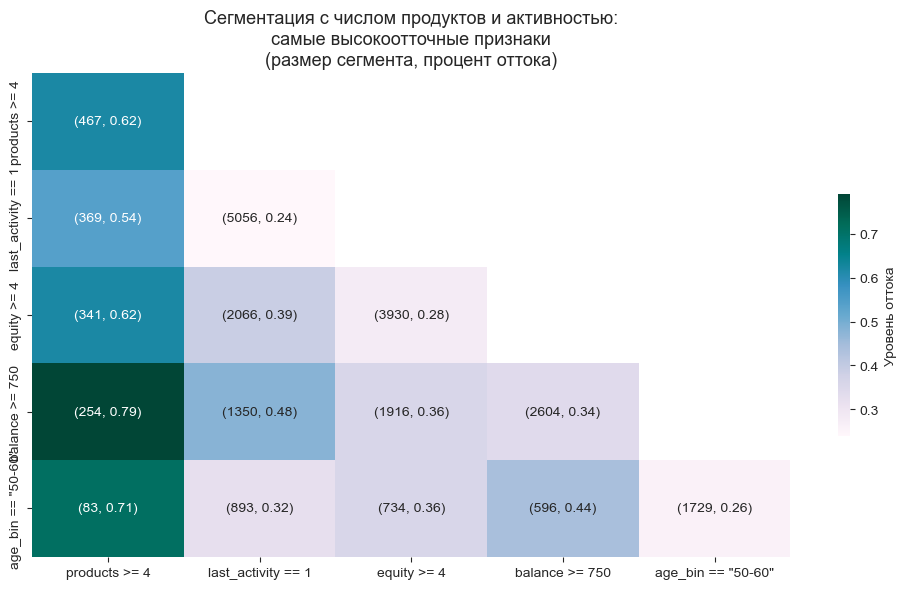

In [88]:
# построим тепловую карту по дополнительным сегментам
plot_paired_conditions(pair_conditions(df, top_churn_cond), figsize=(10,6))
plt.title('Сегментация с числом продуктов и активностью:\nсамые высокоотточные признаки\n(размер сегмента, процент оттока)', 
          fontsize=13);

Если причина того, что наличие активности ведет к повышенному оттоку, не станет препятствием для воздействия на клиента, можно использовать его в паре с балансом как дополнительный сегмент.

In [89]:
print('Наличие активности и баланс от 750 тыс.:')
describe_segment(df.query('last_activity == 1 & balance >= 750'))

Наличие активности и баланс от 750 тыс.:
- Размер сегмента – 1350
- Отток – 48%
(643 отточных, 707 неотточных)



Если существуют способы повысить удержание клиентов с большим числом продуктов, результат будет отличный – можно просто брать клиентов, у которых ровно 4 продукта. В комбинации с любым другим признаком получится компактный сегмент с крайне высоким уровнем оттока (не менее 60%).

<a id='gen_concl'></a>
## Общий вывод

Исследование проводилось на данных о клиентах регионального банка. Поводом для их анализа стал высокий уровень оттока в последнее время.

Цель – выделить сегменты с повышенным оттоком, чтобы маркетинговый отдел провел небольшие рекламные кампании и за счет тагретирования высокоотточных клиентов снизил общий уровень оттока.

**Выделенные высокоотточные сегменты**

[Составление сегментов](#segmentation) проводилось с учетом уровня оттока, размера сегментов и стратегической значимости используемых признаков (могут дать полезную характеристику сформированной группе клиентов).

1. Сегмент "Инвесторы":<br>мужчины в возрасте до 35 или 50-60 лет с балансом на счете от 750 тыс.
- Продукт: вклады, накопительные счета, инвестиции
- Размер сегмента – 582
- Отток – 56%
(325 отточных, 257 неотточных)

2. Сегмент "Кредитные":<br>мужчины без кредитной карты с баллом собственности от 3 и более.
- Продукт: кредитные карты
- Размер сегмента – 856
- Отток – 46%
(396 отточных, 460 неотточных)

3. Сегмент "Ипотечники":<br>клиенты в возрасте до 40 лет с балансом на счете от 600 тыс. и баллом кредитного скоринга 820-900.
- Продукт: ипотечное кредитование 
- Размер сегмента – 714
- Отток – 40%
(284 отточных, 430 неотточных)

4. Сегмент "Страховые":<br>клиенты в возрасте 50-60 лет с зарплатой от 100 тыс. и баллом собственности от 3 и выше.
- Продукт: страхование авто, недвижимости, жизни, здоровья
- Размер сегмента – 483
- Отток – 41%
(199 отточных, 284 неотточных)

**Признаки, связанные с повышенной отточностью**

Уровень [корреляции](#corr) признаков с отточностью:
- Число баллов собственности – 34%
- Баланс – 29%
- Число продуктов – 26%
- Активность в последнем месяце – 25%
- Балл кредитного скоринга – 23%
- Пол клиента – 22%
- Наличие кредитной карты – 20%
- Возраст – 18%
- Зарплата – 6%
- Город – 2%

Значения, связанные с повышенным оттоком:
- Число баллов собственности – от 3 и выше, отток 20-39%
- Баланс – от 750 тыс., отток 34%
- Число продуктов – от 3 и выше, отток 29-62%
- Активность в последнем месяце – наличие активности, отток 24%
- Балл кредитного скоринга – 820-900 баллов, отток 24%
- Пол клиента – мужской, отток 25%
- Наличие кредитной карты – отсутствие карты, отток 25%
- Возраст – до 35 лет и 50-60 лет, отток 21% и 26% соотв-но
- Зарплата – 100-225 тыс., отток 20%
- Город – Ярославль или Ростов, отток 19%

Следует обратить внимание на [повышенный отток среди клиентов с большим числом продуктов и наличием активности](#products_activity). Уход самых лояльных клиентов может говорить о проблемах с качеством сервиса. Стоит выяснить причину крайне высокого оттока в этих категориях.

Полное описание связи с отточностью и диапазоны высокоотточных значений перечислены в [таблице признаков](#eda_concl).

**Портреты отточного и лояльного клиентов**

[Портрет](#profiles) отточного клиента:
- Пол – чаще мужчина (65%);
- Возраст – 39 лет;
- Баланс на счете – около 770 тыс.;
- Баллов собственности – в среднем 3.8;
- Продуктов – в среднем 2.4;
- Была активность в последнем месяце (70%);
- Зарплата – 124 тыс.;
- Балл кредитного скоринга – 862.

Портрет лояльного клиента:
- Возраст – 40 лет;
- Баланс на счете – около 473 тыс.;
- Баллов собственности – в среднем 2.4;
- Продуктов – в среднем 1.8;
- Имеет кредитную карту (70%);
- Зарплата – 117 тыс.;
- Балл кредитного скоринга – 845.

**Данные**

Датасет `bank_scrooge.csv` – содержит перечень клиентов и их основные характеристики, а также признак отточности (клиент ушел или собирается уходить). Выгружен из внутренних систем банка. Размер – 10000 наблюдений. Качество данных в целом хорошее.

Обнаруженные проблемы в данных:

1. Значительное количество отсутствующих значений в столбце `balance` (баланс на счете, 23%) и немного в `age` (возраст, 3%). Пропуски не случайны.
2. Дублируются уникальные идентификаторы между Ярославлем и Рыбинском – 73 идентификатора между городами совпадают. Стоит проверить механизм присвоения `user_id`.

## Презентация результатов анализа

Материалы:
1. [Файл презентации в формате pdf](https://drive.google.com/file/d/1dKgehNBXwoLJyia5N5w7GMJQupBan14M/view?usp=sharing) на Google Диске.
2. [Дашборд на Tableau Public](https://public.tableau.com/views/YP_DA_banks_alex4d_exe/sheet1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) по уровню оттока в разрезе количества продуктов клиента. 
